In [6]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from helper import fields, interface, fields_original, from_matrix, RealWave
from fio import readin
working_dir = '/media/jiarong/Elements/projects/windwave2D/rerun/'
import matplotlib as mpl
from matplotlib import ticker
from case import Case
import pickle
mpl.style.use('pof')

## Vorticity comparision between pure wave in viscous fluid and wind wave.

<ipython-input-10-a882f6056dec>:22: MatplotlibDeprecationWarning: Since 3.2, mpl_toolkits's own colorbar implementation is deprecated; it will be removed two minor releases later.  Set the 'mpl_toolkits.legacy_colorbar' rcParam to False to use Matplotlib's default colorbar implementation and suppress this deprecation warning.
  grid[0].cax.colorbar(pcontour)
<ipython-input-10-a882f6056dec>:25: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.savefig(working_dir+'plots/rev_omega_nowind.pdf', pad_inches=0.1)
/home/jiarong/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


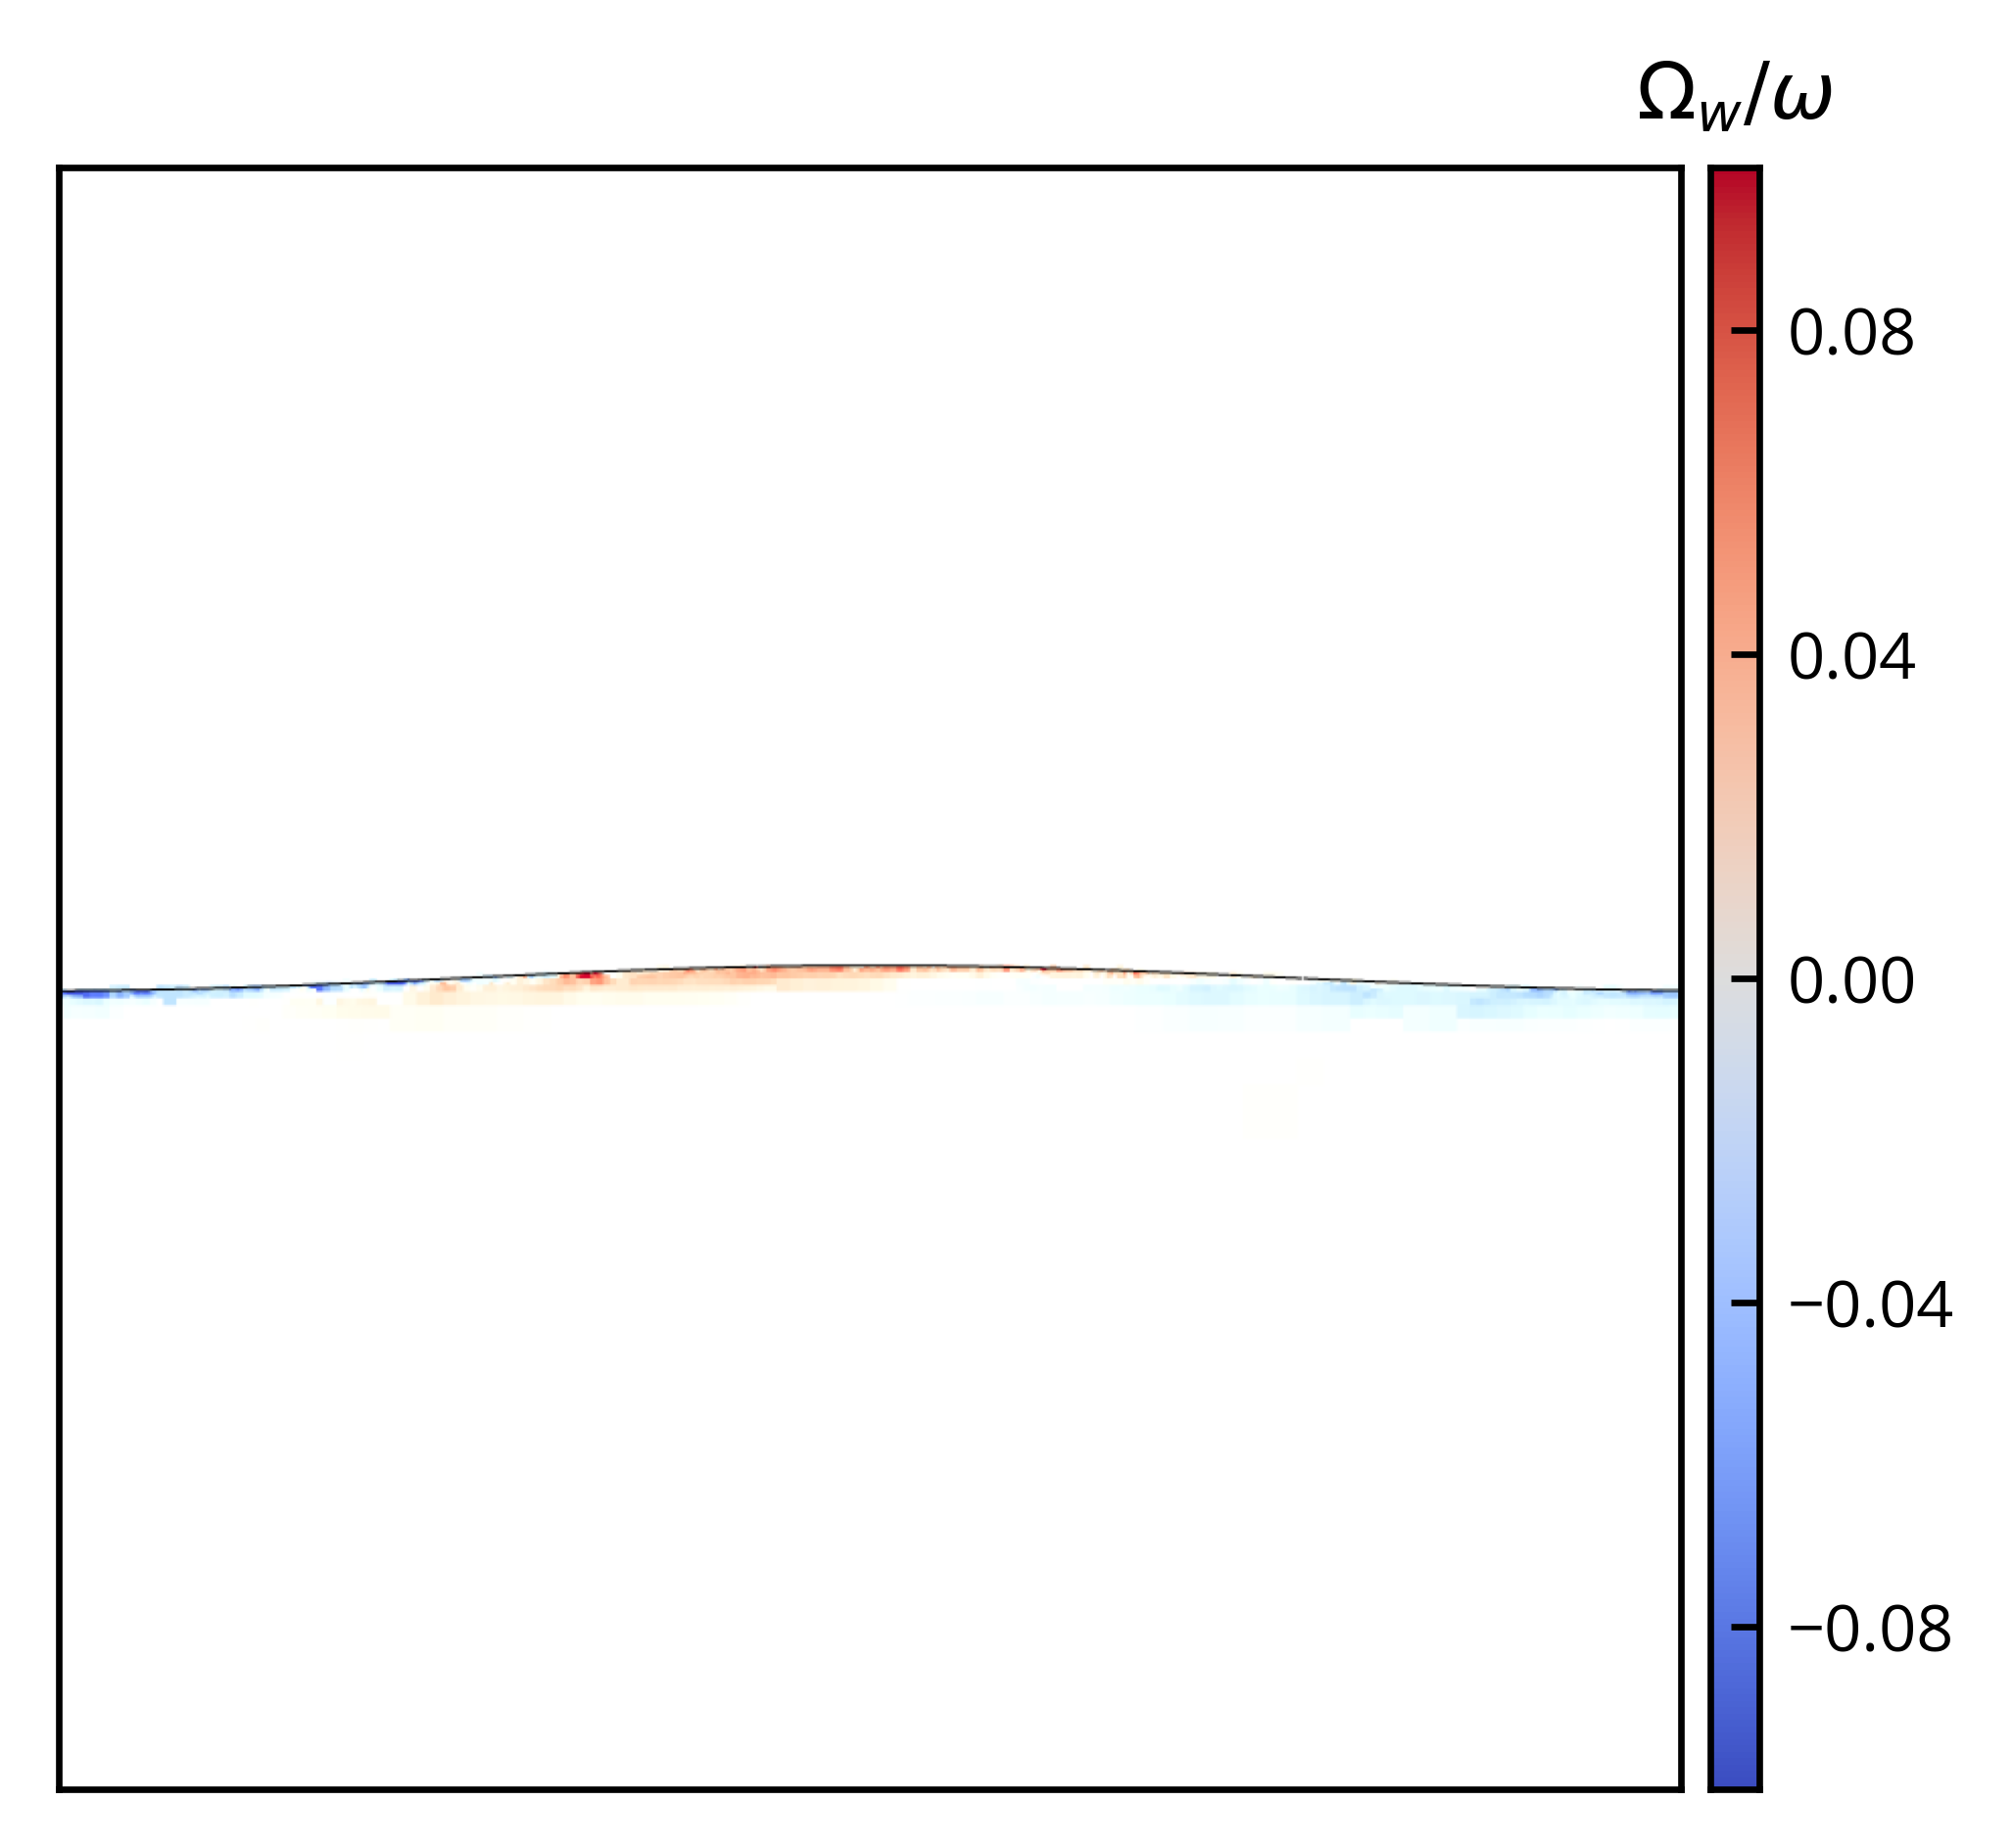

In [10]:
""" Show the water side vorticity. No wind.
"""
fig = plt.figure(figsize=(4,3))
import matplotlib.image as mpimg
from mpl_toolkits.axes_grid1 import ImageGrid
grid = ImageGrid(fig, 111,          # as in plt.subplot(111)
                 nrows_ncols=(1,1),
                 axes_pad=0.05,
                 share_all=True,
                 cbar_location="right",
                 cbar_mode="single",
                 cbar_size="3%",
                 cbar_pad=0.05,
                 )
path = '/media/jiarong/Elements/projects/windwave2D/rerun/linear_wavewind_nowind_dirac_Ustar0ak0.05Bo0.53Re5000.LEVEL11'
t = 2
u_air, u_water, omega_air, omega_water = fields (path, t)
# We can plot anything as long as the cmap and vmax vmin matches the output from bview
pcontour = grid[0].imshow(np.rot90(omega_water), vmax = 0.1, vmin = -0.1, cmap='coolwarm')
img = mpimg.imread(path + '/movies/omega%g.png' %t, 0)
grid[0].imshow(img)
grid[0].cax.colorbar(pcontour)
grid[0].set_xticks([]); grid[0].set_yticks([]);
grid[0].cax.set_title(r'$\Omega_w/\omega$')
fig.savefig(working_dir+'plots/rev_omega_nowind.pdf', pad_inches=0.1)

<ipython-input-7-f1862090136c>:22: MatplotlibDeprecationWarning: Since 3.2, mpl_toolkits's own colorbar implementation is deprecated; it will be removed two minor releases later.  Set the 'mpl_toolkits.legacy_colorbar' rcParam to False to use Matplotlib's default colorbar implementation and suppress this deprecation warning.
  grid[0].cax.colorbar(pcontour)
<ipython-input-7-f1862090136c>:25: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.savefig(working_dir+'plots/rev_omega_wind.pdf', pad_inches=0.1)
/home/jiarong/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


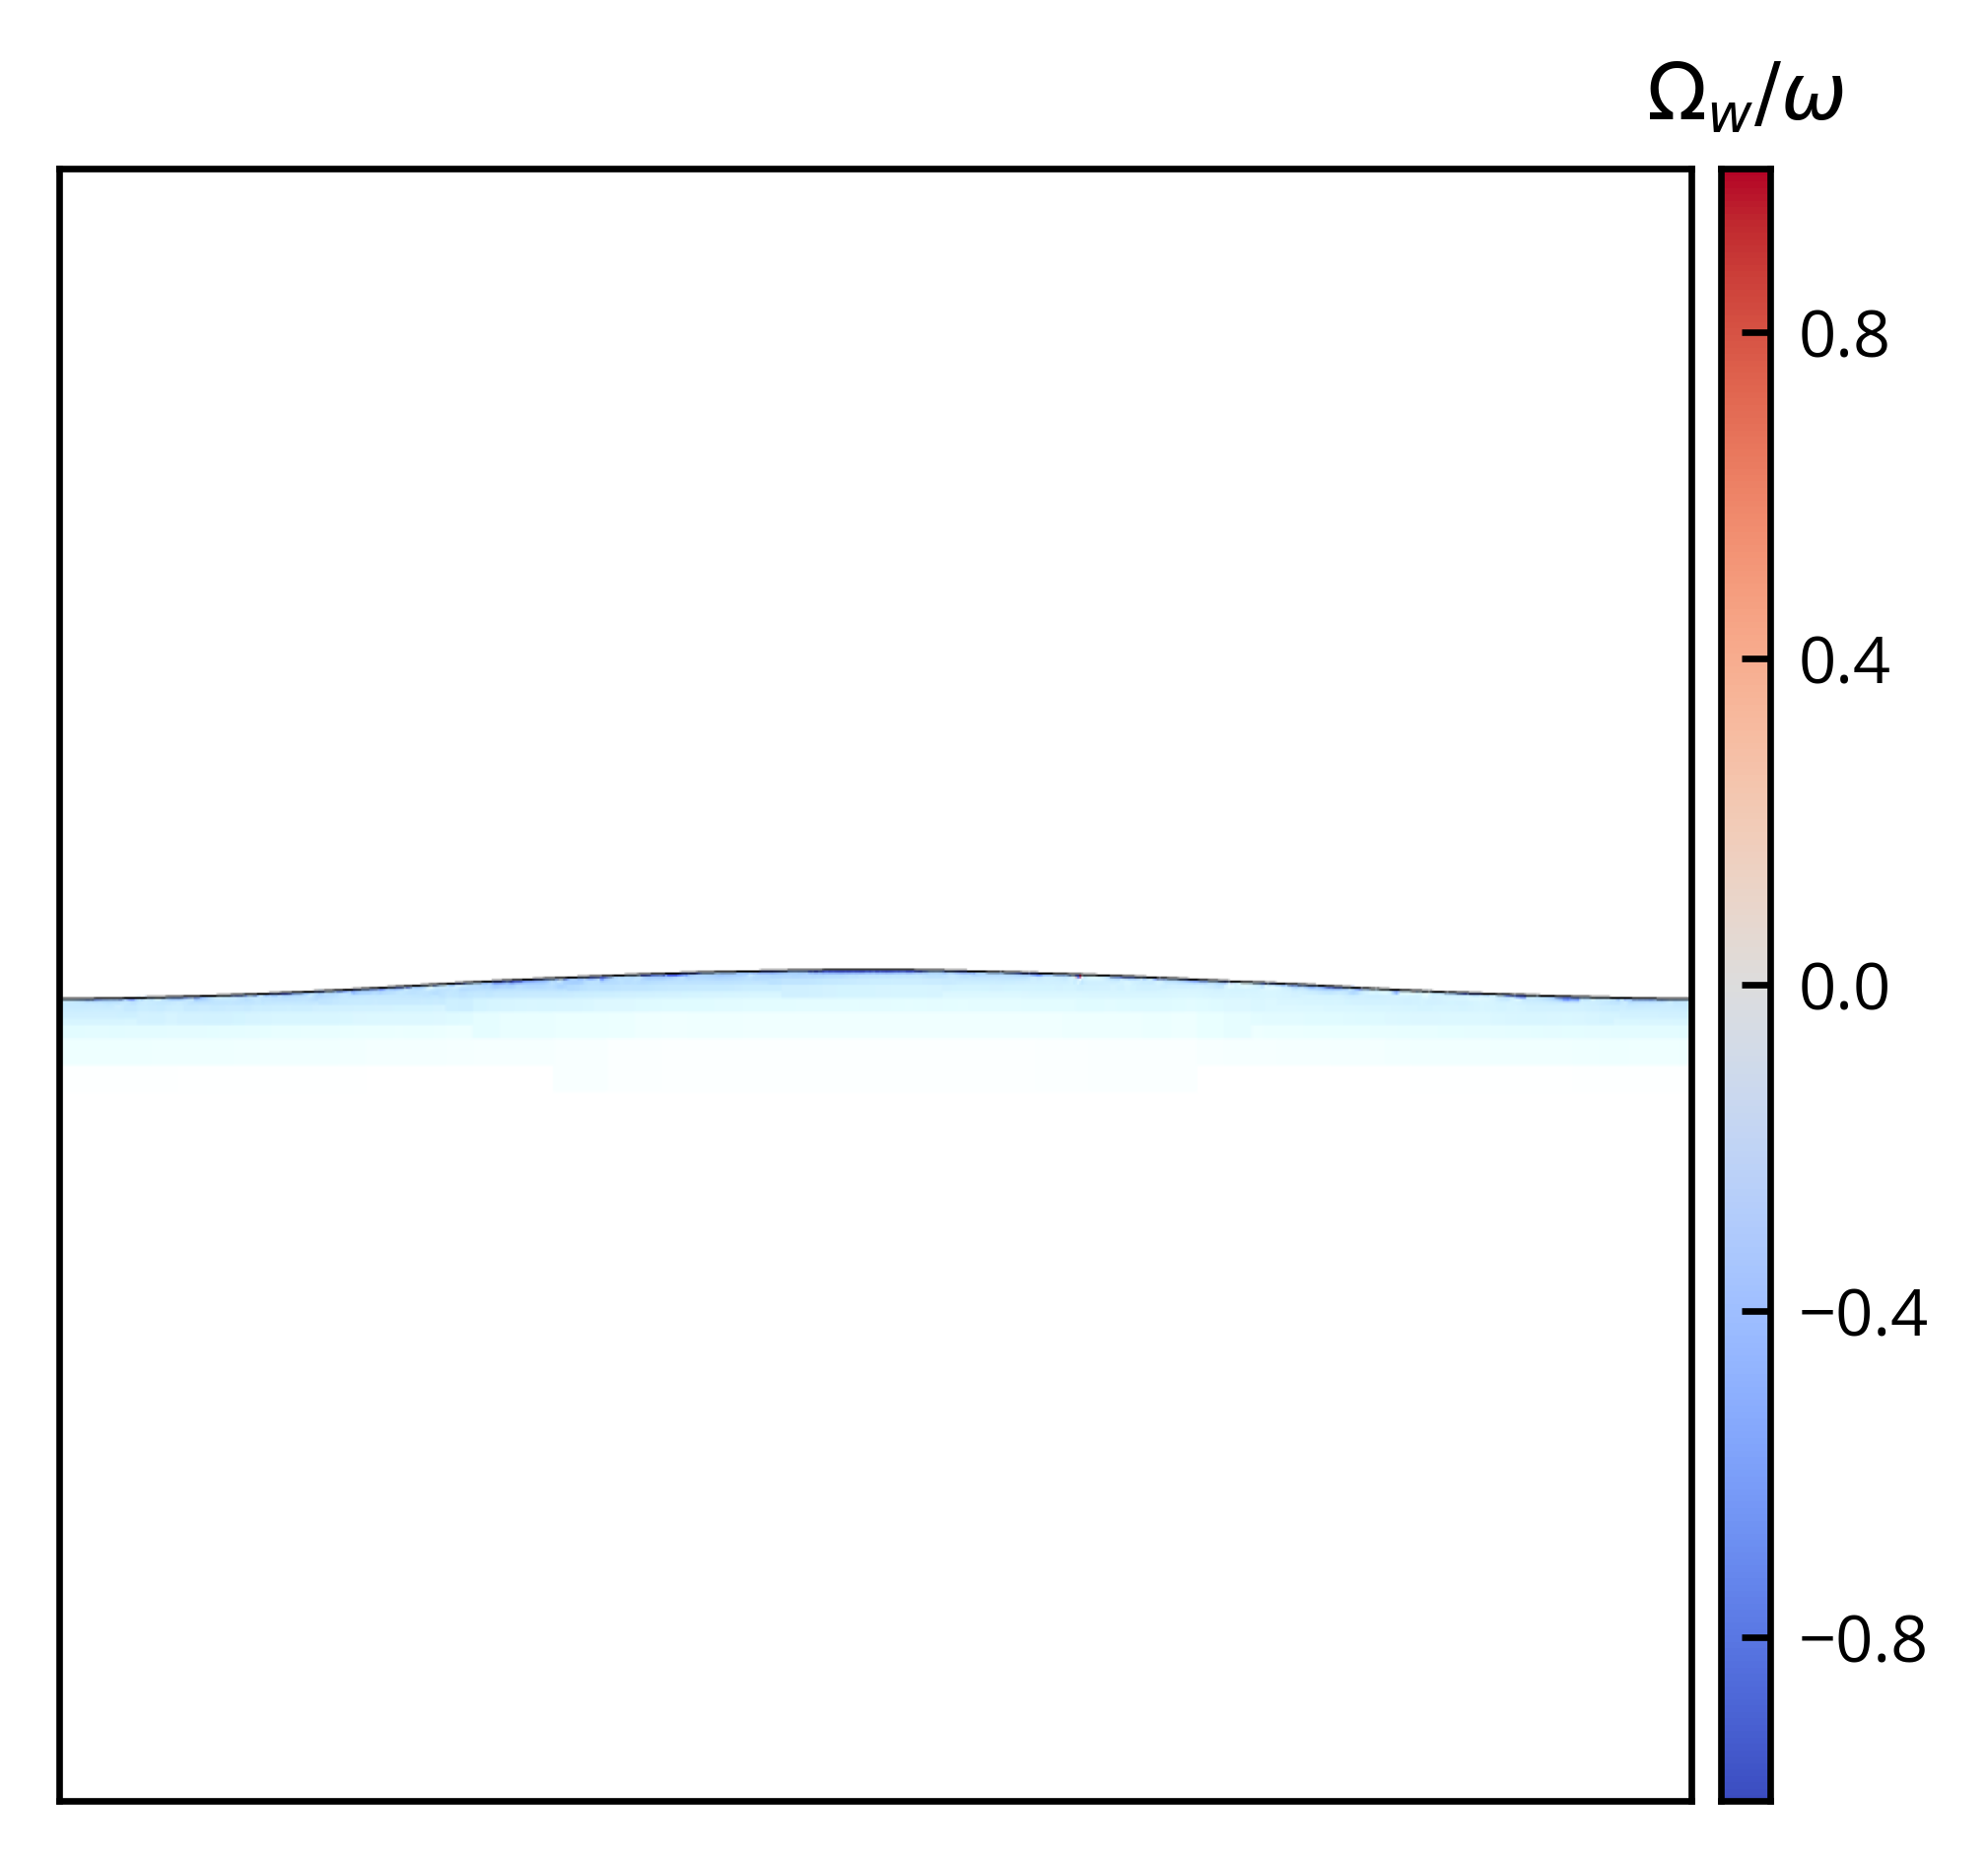

In [7]:
""" Show the water side vorticity. With wind.
"""
fig = plt.figure(figsize=(4,3))
import matplotlib.image as mpimg
from mpl_toolkits.axes_grid1 import ImageGrid
grid = ImageGrid(fig, 111,          # as in plt.subplot(111)
                 nrows_ncols=(1,1),
                 axes_pad=0.05,
                 share_all=True,
                 cbar_location="right",
                 cbar_mode="single",
                 cbar_size="3%",
                 cbar_pad=0.05,
                 )
path = '/media/jiarong/Elements/projects/windwave2D/rerun/linear_wavewind_rerun_test_Ustar0.8ak0.05Bo0.53Re5000.LEVEL11'
t = 2
u_air, u_water, omega_air, omega_water = fields (path, t)
# We can plot anything as long as the cmap and vmax vmin matches the output from bview
pcontour = grid[0].imshow(np.rot90(omega_water), vmax = 1, vmin = -1, cmap='coolwarm')
img = mpimg.imread(path + '/movies/omega%g.png' %t, 0)
grid[0].imshow(img)
grid[0].cax.colorbar(pcontour)
grid[0].set_xticks([]); grid[0].set_yticks([]);
grid[0].cax.set_title(r'$\Omega_w/\omega$')
fig.savefig(working_dir+'plots/rev_omega_wind.pdf', pad_inches=0.1)

In [8]:
from scipy.signal import hilbert
def u_partition (path, t, eta, Bo=0.27, L0=1, N=512, CAPI=False): 
    u_air, u_water, omega_air, omega_water = fields(path,t)
    u,f,omega = fields_original(path,t)
    ak = np.std(eta)*2*np.pi*2**0.5
    x_eta = np.linspace(-L0/2,L0/2,np.size(eta),endpoint = False) + L0/np.size(eta)/2
    # Construct mesh (of size N)
    x = np.linspace(-L0/2,L0/2,N,endpoint = False) + L0/N/2
    z = np.linspace(-L0/2,L0/2,N,endpoint = False) + L0/N/2
    eta_interp = np.interp(x, x_eta, eta)
    # Hilbert transformation to get the phase
    analytic_signal = hilbert(eta_interp)
    phase = np.unwrap(np.angle(analytic_signal))
    z_tile, phase_tile = np.meshgrid(z,phase)
    # Linear wave velocity field; a bunch of parameters are specified
    c_ = 0.51713; k_ = 2.*np.pi
    # Using linear relation
#     ux = ak*c_*np.cos(phase_tile)*np.exp(k_*z_tile)
#     uy = ak*c_*np.cos(phase_tile-np.pi/2.)*np.exp(k_*z_tile)
    # Using Stokes wave
    ux,uy = stokes(phase_tile,z_tile,Bo,ak,L0,CAPI)
    ux_irrot = ux
    uy_irrot = uy
    # A different f field computed from interpolated eta
    for i in range(0,N):
        for j in range(0,N):
            if (z_tile[i,j]>=eta_interp[i]):
                ux_irrot[i,j] = 0.
                uy_irrot[i,j] = 0.
    ugroup = (u_water, ux_irrot,u_water-ux_irrot, uy_irrot)
    return ugroup

In [5]:
path = '/home/jiarong/research/projects/windwave/rerun/linear_wavewind_nowind_dirac_Ustar0ak0.05Bo0.53Re5000.LEVEL11'
u_air, u_water, omega_air, omega_water = fields (path, 2)
# u,f,omega = fields_original(path,t)

Text(1.05, 1.1, '$\\Omega$')

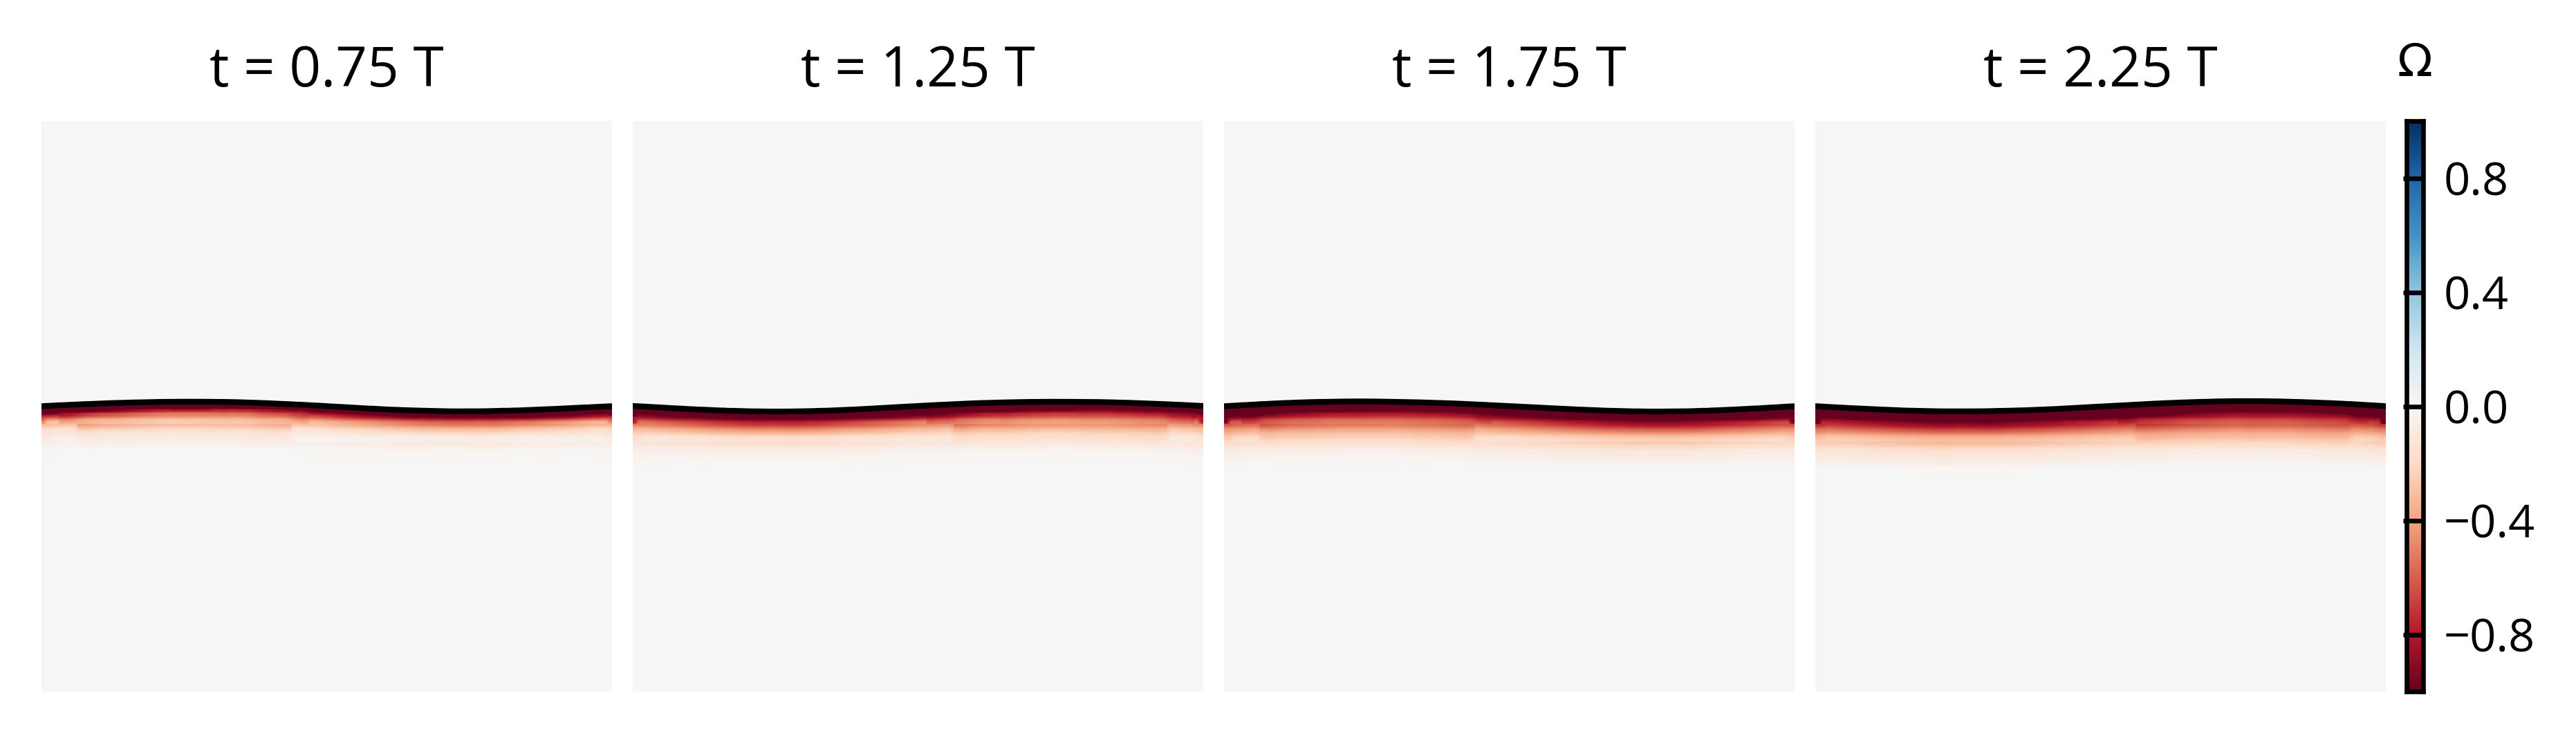

In [21]:
path = '/home/jiarong/research/projects/windwave/rerun/linear_wavewind_rerun_test_Ustar0.8ak0.05Bo0.53Re5000.LEVEL11'

from mpl_toolkits.axes_grid1 import ImageGrid
fig = plt.figure(figsize=(6,3))
grid = ImageGrid(fig, 111,          # as in plt.subplot(111)
                 nrows_ncols=(1,4),
                 axes_pad=0.05,
                 share_all=True,
                 cbar_location="right",
                 cbar_mode="single",
                 cbar_size="3%",
                 cbar_pad=0.05,
                 )
for t,ax in zip([0.75,1.25,1.75,2.25],[grid[0],grid[1],grid[2],grid[3]]):
    u_air, u_water, omega_air, omega_water = fields (path, t)
    ampl = interface(path, Npoint=512, L0=1, time=t)
    pcontour = ax.imshow(np.rot90(omega_water),vmax = 1, vmin = -1, extent = (-L0/2,L0/2,-L0/2,L0/2), cmap='RdBu')
    ax.plot(ampl.x_interp, ampl.eta_interp, 'k', lw = 1)
    ax.set_axis_off()
    ax.set_title("t = %g T" %t)
grid[3].cax.colorbar(pcontour)
ax.text(1.05,1.1, r'$\Omega$', ha='center', va='center', transform=ax.transAxes)

Text(1.05, 1.1, '$\\Omega_{\\nu}$')

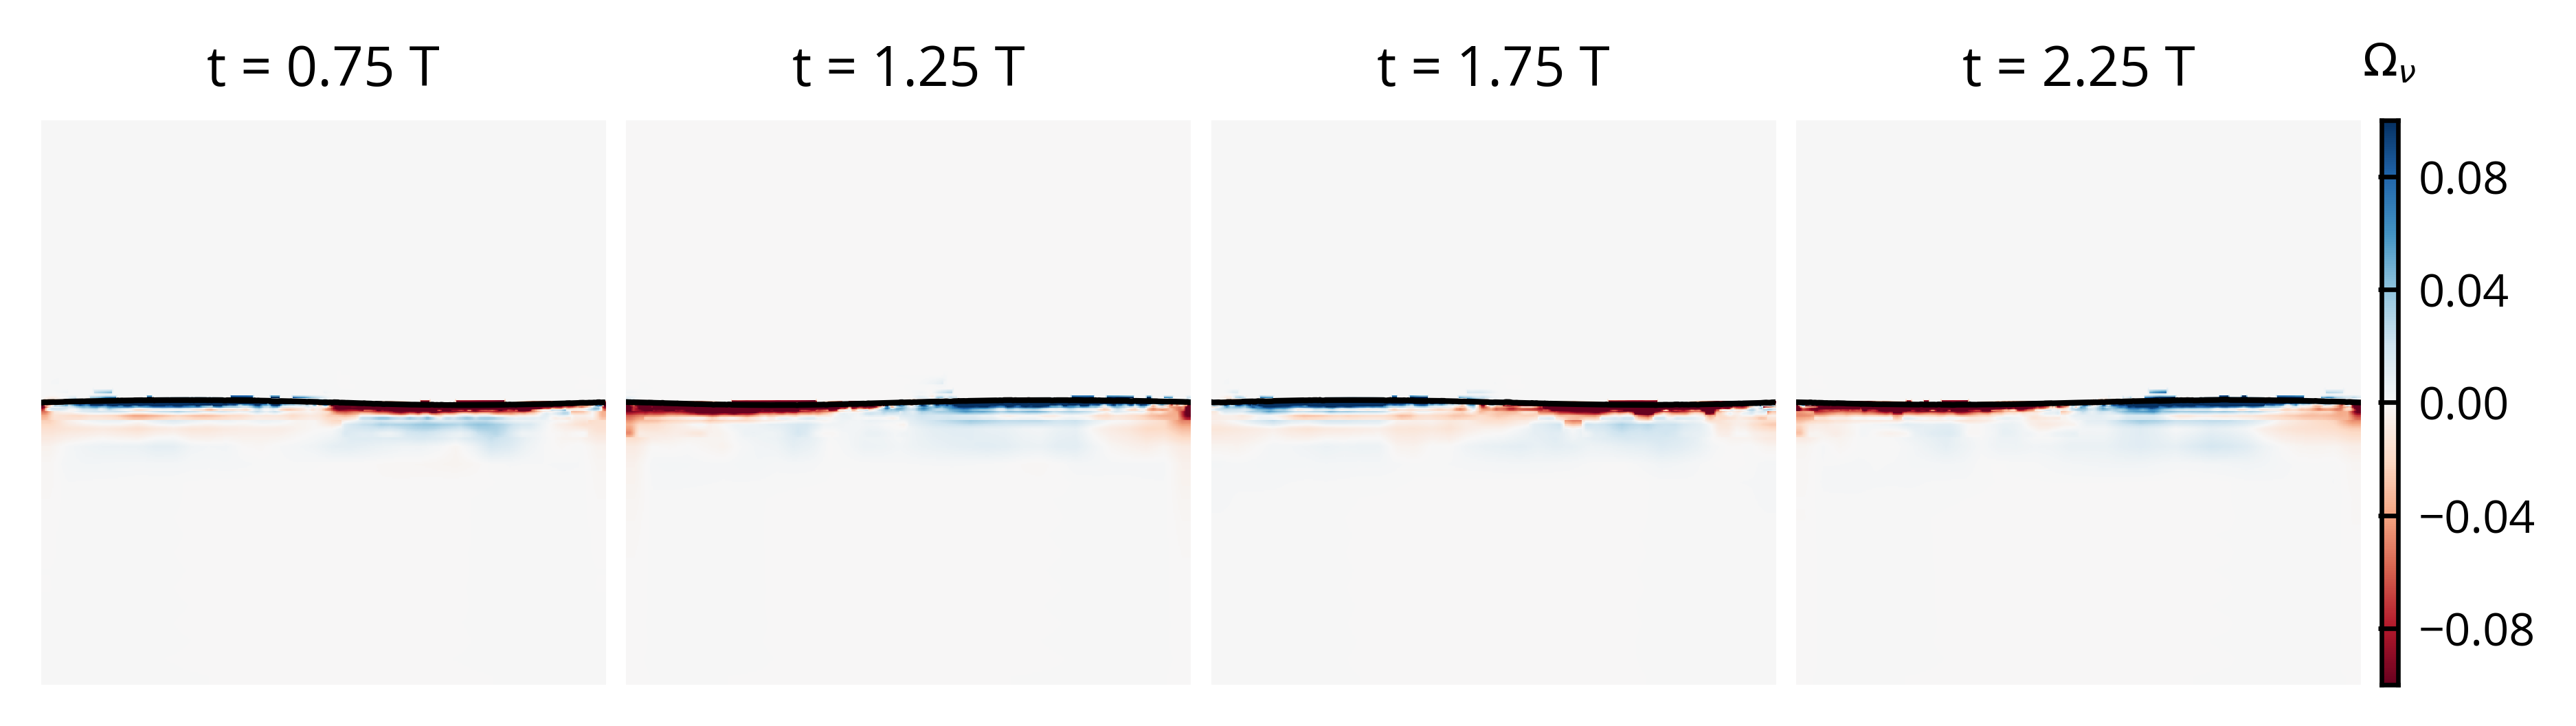

In [23]:
path = '/home/jiarong/research/projects/windwave/rerun/linear_wavewind_nowind_dirac_Ustar0ak0.05Bo0.53Re5000.LEVEL11'

from mpl_toolkits.axes_grid1 import ImageGrid
fig = plt.figure(figsize=(6,3))
grid = ImageGrid(fig, 111,          # as in plt.subplot(111)
                 nrows_ncols=(1,4),
                 axes_pad=0.05,
                 share_all=True,
                 cbar_location="right",
                 cbar_mode="single",
                 cbar_size="3%",
                 cbar_pad=0.05,
                 )
for t,ax in zip([0.75,1.25,1.75,2.25],[grid[0],grid[1],grid[2],grid[3]]):
    u_air, u_water, omega_air, omega_water = fields (path, t)
    ampl = interface(path, Npoint=512, L0=1, time=t)
    pcontour = ax.imshow(np.rot90(omega_water),vmax = 0.1, vmin = -0.1, extent = (-L0/2,L0/2,-L0/2,L0/2), cmap='RdBu')
    ax.plot(ampl.x_interp, ampl.eta_interp, 'k', lw = 1)
    ax.set_axis_off()
    ax.set_title("t = %g T" %t)
grid[3].cax.colorbar(pcontour)
ax.text(1.05,1.1, r'$\Omega_{\nu}$', ha='center', va='center', transform=ax.transAxes)

## Fixed the drift profile plot (TODO: check the intepolation again)

In [71]:
from scipy.interpolate import interp1d

""" The old water profile interpolation function. """
def water_profile(t,path,L0):
    # Read in the fields
    u_air, u_water, omega_air, omega_water = fields(path, t)
    # Average profile (wave coordinate!)
    u_water_1D_nointerp = np.average(u_water, axis=0)
    u_water_interp = np.zeros(u_water.shape)
    ampl = interface(path, Npoint=512, L0=1, time=t)
    zmax = L0/2 - ampl.eta_interp.max(); zmin = -L0/2 - ampl.eta_interp.min()
    zgrid = np.linspace(zmin, zmax, 512)
    for i in range(u_water.shape[0]):
        z = np.linspace(-L0/2,L0/2,512) - ampl.eta_interp[i]
        f = interp1d(z, u_water[i,:])
        ugrid = f(zgrid)
        u_water_interp[i] = ugrid
    u_water_1D = np.average(u_water_interp[:,:], axis=0)
    return u_water, u_water_interp, u_water_1D, zgrid


""" REWRITTEN water profile interpolation function! """
def water_profile_new(t,path,L0):
    # Read in the fields
    u_air, u_water, omega_air, omega_water = fields(path, t)
    # Average profile (wave coordinate!)
    u_water_interp = np.zeros(u_water.shape)
    ampl = interface(path, Npoint=512, L0=1, time=t)
#     zmax = L0/2 - ampl.eta_interp.max(); zmin = -L0/2 - ampl.eta_interp.min()
#     zgrid = np.linspace(zmin, zmax, 512) # The range of z'
    zplot = np.zeros(u_water.shape) # To show in the original cartesian grid z where the interpolating grid z' is
    for i in range(u_water.shape[0]):
        z = np.linspace(-L0/2,L0/2,512,endpoint=False) + L0/2/512
        f = interp1d(z, u_water[i,:])
        # The ratio to make sure that the cartesian representation of z' falls within the domain
        ratio = (L0/2 - np.abs(ampl.eta_interp[i]) - L0/2/512)/256 
        zgrid = ratio*np.arange(-256,256) + ampl.eta_interp[i] 
        zplot[i] = zgrid
        ugrid = f(zgrid)
        u_water_interp[i] = ugrid
    u_water_1D = np.average(u_water_interp[:,:], axis=0)
    return u_water, u_water_interp, u_water_1D, zgrid, zplot

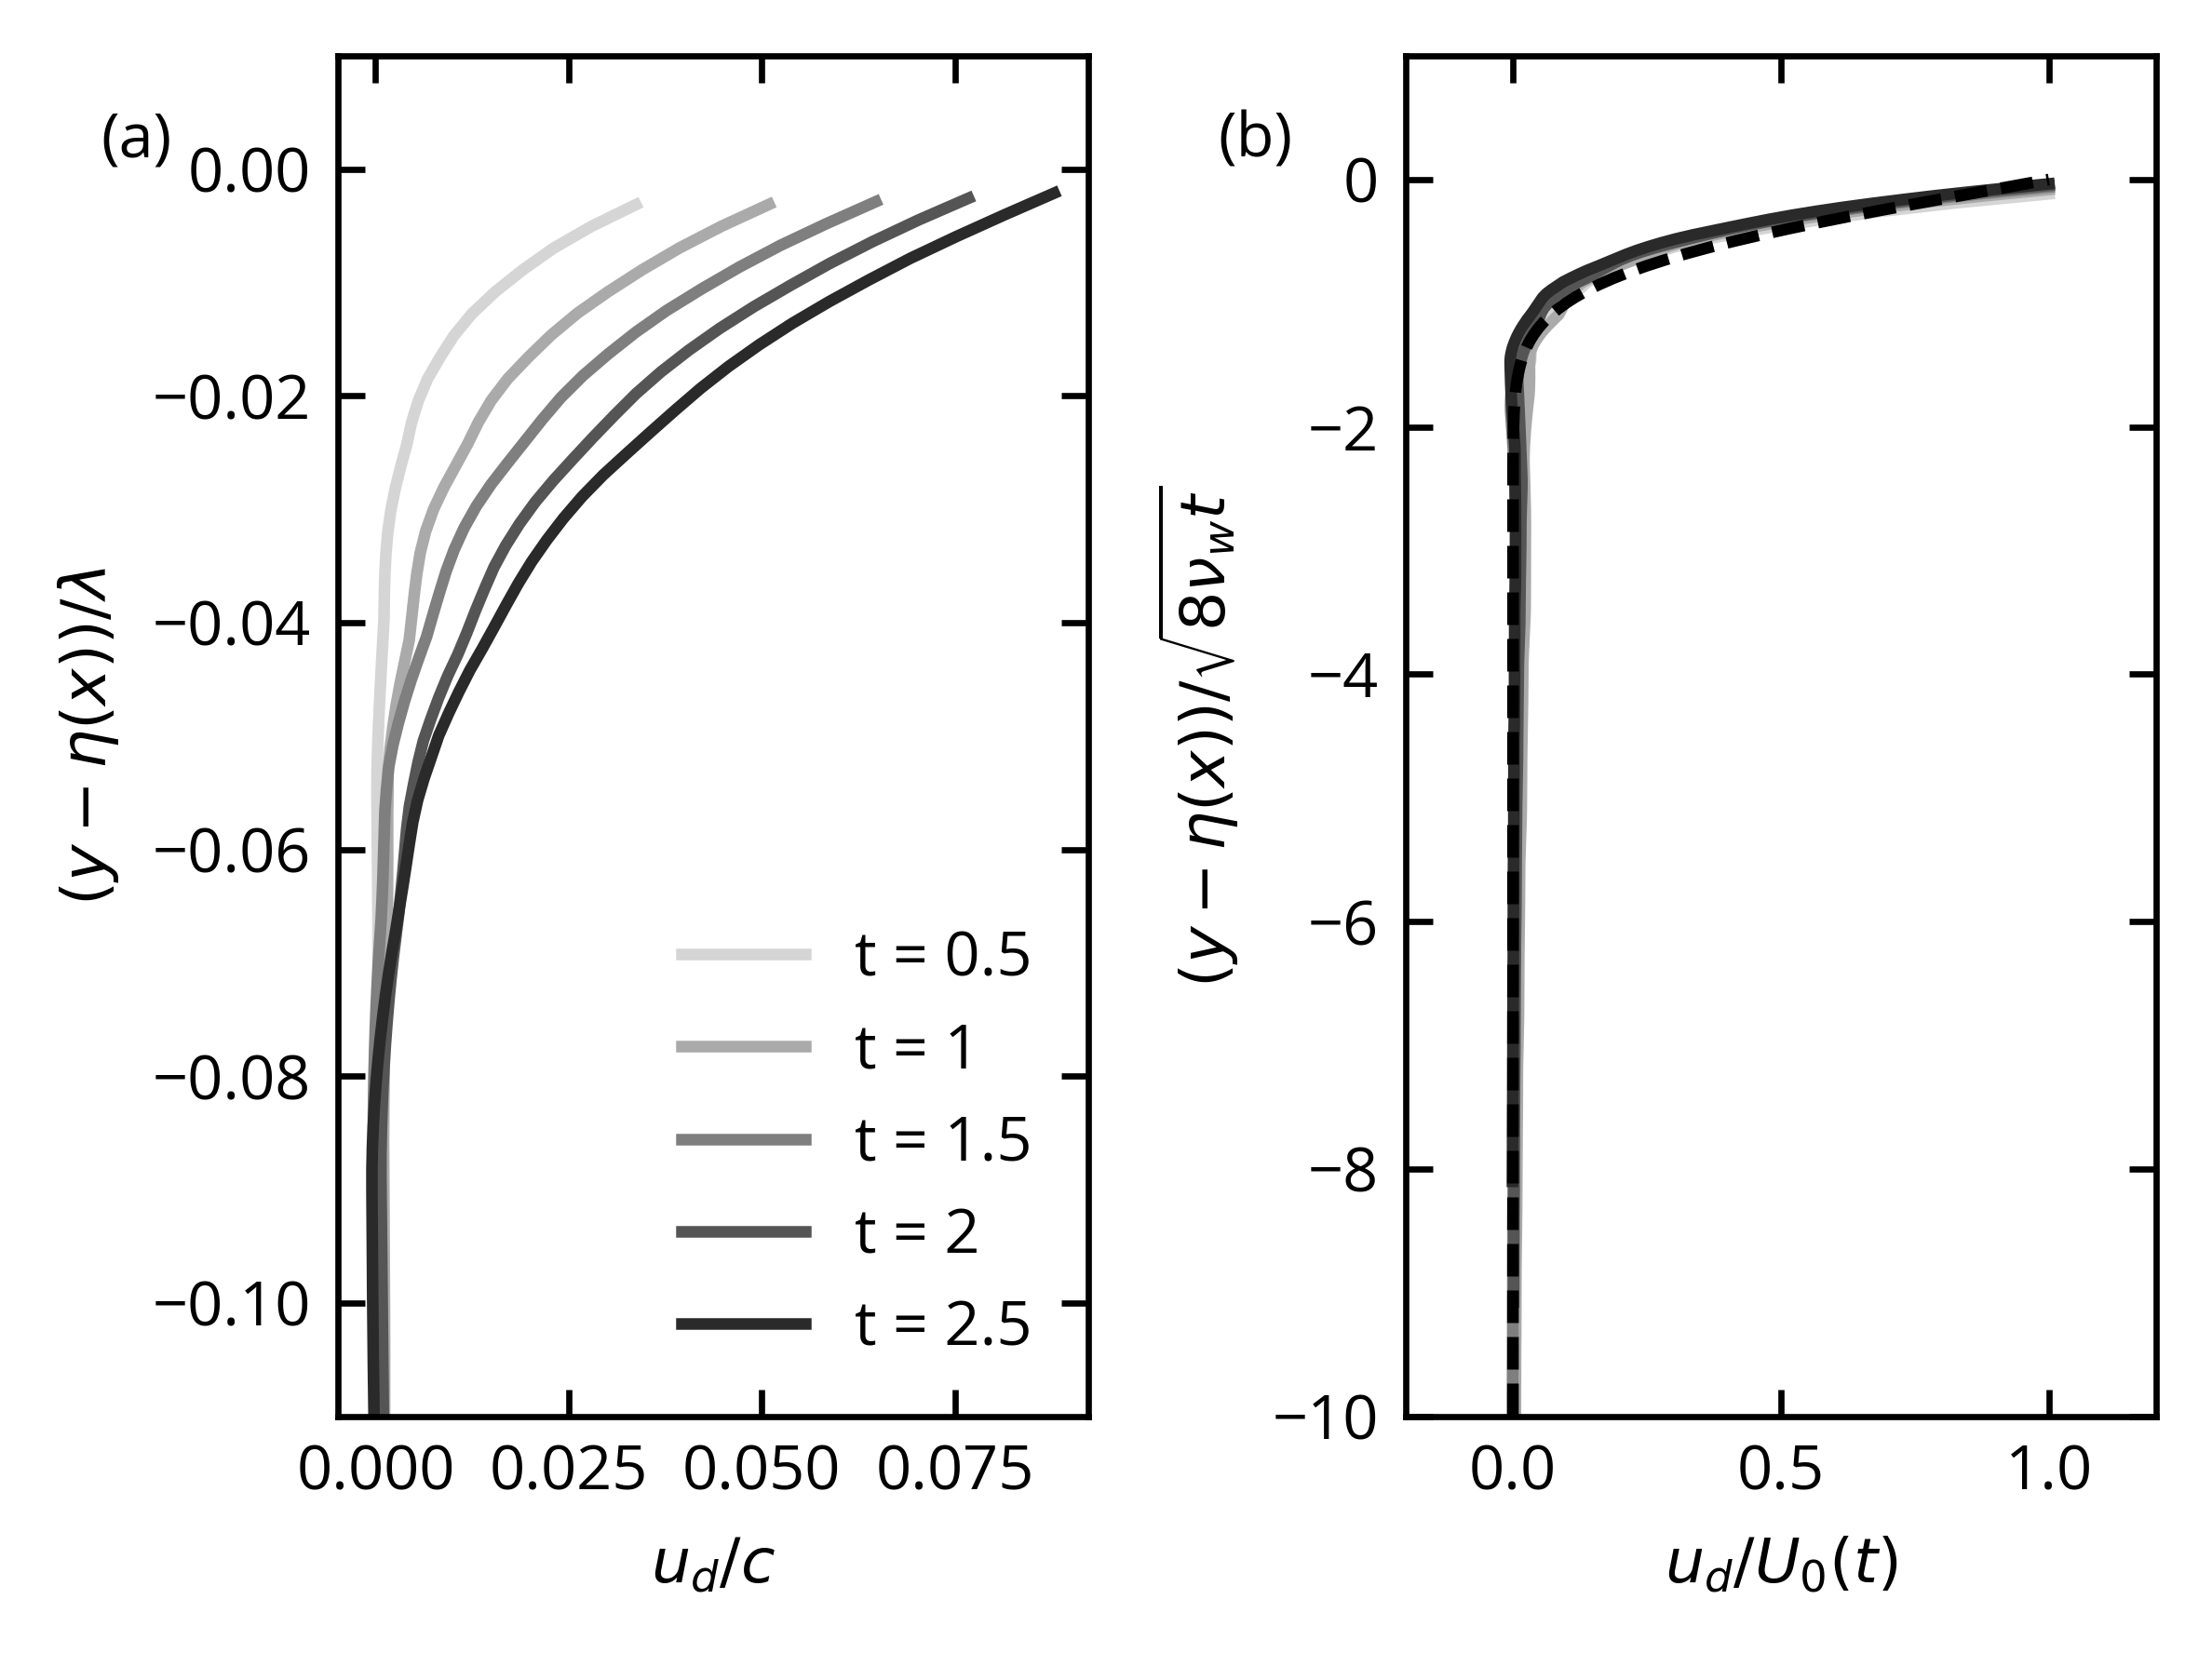

In [77]:
'''
Shear with only stress.
'''

# Plot the 1D shear and normalization
from scipy.special import pbdv, gamma
from matplotlib import gridspec

L0 = 1
fig = plt.figure(figsize=(4,3)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[1,1]) 
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
N_time = 6

# case = Case(ustar=0.8, ak=0, Bo=1.47, Re=10660, LEVEL=11, L0=1., g=1., k=2.*np.pi,
#             working_dir = '/home/jiarong/research/projects/windwave/rerun/', 
#             prefix = 'linear_wavewind_rerun_test_particle_')
# case = Case(ustar=1, ak=0, Bo=0.53, Re=5000, LEVEL=11, L0=1., g=1., k=2.*np.pi,
#             working_dir = '/home/jiarong/research/projects/windwave/rerun/', 
#             prefix = 'linear_wavewind_rerun_test_particle_')
case = Case(ustar=0.8, ak=0.05, Bo=1.47, Re=10660, LEVEL=11, L0=1., g=1., k=2.*np.pi,
            working_dir = '/home/jiarong/research/projects/windwave/rerun/', 
            prefix = 'linear_wavewind_rerun_test_')
# case = Case(ustar=0.5, ak=0, Bo=0.53, Re=5000, LEVEL=9, L0=1., g=1., k=2.*np.pi,
#             working_dir = '/home/jiarong/research/projects/windwave/rerun/', 
#             prefix = 'linear_wavewind_rerun_test_fixed_')
case.t = np.arange(0,96)/32
for i in range (1,N_time):
    t = case.t[i*16]
    """ TODO: This is not actually interpolated!!! """
    u_water, u_water_interp, u_water_1D, ygrid = water_profile(t,case.path,case.L0)
#     u_water, u_water_interp, u_water_1D, ygrid, yplot_2D = water_profile_new(t,case.path,case.L0)
    ax1.plot(u_water_1D[0:255]/case.wave.c, ygrid[0:255]/L0, '-', label = 't = %g' %t, color=plt.cm.get_cmap('binary')(i/N_time))
    U0_analy = (t*2*np.pi/case.wave.omega*case.Re)**0.5*(case.ustar*case.wave.c)**2*gamma(1)/gamma(3/2)/850
    U0 = np.max(u_water_1D[0:255])
    ax2.plot(u_water_1D[0:255]/U0, ygrid[0:255]/L0/(8*(1/case.Re)*case.t[i*16]*2*np.pi/case.wave.omega)**0.5, '-', color=plt.cm.get_cmap('binary')(i/N_time))
u_stokes = np.exp(ygrid[0:255]*2*case.wave.k)*0.1**2*case.wave.c
# ax1.plot(u_stokes, ygrid[0:255], '--')
# y_ = ygrid[0:255]/L0/(8*(1/case.Re)*case.t[i]*2*np.pi/case.wave.omega)**0.5
y_ = np.arange(-10,0.05,0.05)
ratio = 1
u_ = gamma(3/2)*2/np.pi**0.5*np.exp(-(y_/ratio)**2)*pbdv(-2,-(y_/ratio))[0]
ax2.plot(u_, y_, '--', color='k')
ratio = 1.41
u_ = gamma(3/2)*2/np.pi**0.5*np.exp(-(y_/ratio)**2)*pbdv(-2,-(y_/ratio))[0]
u_stokes = np.exp((y_*(8*(1/case.Re)*case.t[i]*2*np.pi/case.wave.omega)**0.5)*2*case.wave.k)
# u_ = gamma(3/2)*2/np.pi**0.5*np.exp(-y_**2)
# ax2.plot(u_, y_, '--', color='r')
# ax2.plot(u_stokes, y_, '--')
# Show the grid size of level 9
# ax1.plot(np.linspace(0,0.015,100), -1/512*np.ones(100))
ax1.set_ylabel(r'$(y-\eta(x))/\lambda$'); ax1.set_ylim([-0.11,0.01])
ax2.set_ylabel(r'$(y-\eta(x))/\sqrt{8\nu_w t}$')
ax1.set_xlabel(r'$u_{d}/c$'); ax2.set_ylim([-10,1])
ax2.set_xlabel(r'$u_{d}/U_0(t)$'); ax2.set_xlim([-0.2,1.2])
ax1.legend()
ax1.text(0.05, 0.9, '(a)', transform=plt.gcf().transFigure)
ax2.text(0.55, 0.9, '(b)', transform=plt.gcf().transFigure)
fig.tight_layout()
fig.savefig(working_dir + 'plots/rev_drift_1D_ab_corrected_ustar0.8Re10660wave.pdf', bbox_inches='tight', pad_inches=0.1)

In [ ]:
""" A wrapper function that is basically scipy.griddata with method='linear' but will fill in the blank part with 
    values given by method='nearest'.
"""
def griddata_linear_2D (points, values, grid):
grid_z0 = griddata(points, values, (grid_x, grid_y), method='nearest')
grid_z1 = griddata(points, values, (grid_x, grid_y), method='linear')

fill_value = 123  # Whatever you like
grid_z0[np.isnan(grid_z1)] = fill_value

np.interp(self.x_interp, self._eta_data.x, self._eta_data.eta)

## Three different Bond number that run till nonlinear wave stage
### Register the cases

In [3]:
"""Compare threshold for different Bo"""
case_Bo = []
case = Case(ustar=0.4, ak=0.05, Bo=1.47, Re=10660, LEVEL=11, L0=1., g=1., k=2.*np.pi,
     working_dir = '/home/jiarong/research/projects/windwave/rerun/', prefix = 'linear_wavewind_rerun_test_')
case_Bo.append(case)
case = Case(ustar=0.6, ak=0.05, Bo=1.47, Re=10660, LEVEL=11, L0=1., g=1., k=2.*np.pi,
     working_dir = '/home/jiarong/research/projects/windwave/rerun/', prefix = 'linear_wavewind_rerun_test_')
case_Bo.append(case)
case = Case(ustar=1, ak=0.05, Bo=1.47, Re=10660, LEVEL=11, L0=1., g=1., k=2.*np.pi,
     working_dir = '/home/jiarong/research/projects/windwave/rerun/', prefix = 'linear_wavewind_rerun_test_')
case_Bo.append(case)
case = Case(ustar=0.4, ak=0.05, Bo=25, Re=10660, LEVEL=11, L0=1., g=1., k=2.*np.pi,
     working_dir = '/home/jiarong/research/projects/windwave/rerun/', prefix = 'linear_wavewind_rerun_test_')
case_Bo.append(case)
case = Case(ustar=0.6, ak=0.05, Bo=25, Re=10660, LEVEL=11, L0=1., g=1., k=2.*np.pi,
     working_dir = '/home/jiarong/research/projects/windwave/rerun/', prefix = 'linear_wavewind_rerun_test_')
case_Bo.append(case)
case = Case(ustar=1, ak=0.05, Bo=25, Re=10660, LEVEL=11, L0=1., g=1., k=2.*np.pi,
     working_dir = '/home/jiarong/research/projects/windwave/rerun/', prefix = 'linear_wavewind_rerun_test_')
case_Bo.append(case)
case = Case(ustar=0.4, ak=0.05, Bo=200, Re=10660, LEVEL=11, L0=1., g=1., k=2.*np.pi,
     working_dir = '/home/jiarong/research/projects/windwave/rerun/', prefix = 'linear_wavewind_rerun_test_')
case_Bo.append(case)
case = Case(ustar=0.6, ak=0.05, Bo=200, Re=10660, LEVEL=11, L0=1., g=1., k=2.*np.pi,
     working_dir = '/home/jiarong/research/projects/windwave/rerun/', prefix = 'linear_wavewind_rerun_test_')
case_Bo.append(case)
case = Case(ustar=1, ak=0.05, Bo=200, Re=10660, LEVEL=11, L0=1., g=1., k=2.*np.pi,
     working_dir = '/home/jiarong/research/projects/windwave/rerun/', prefix = 'linear_wavewind_rerun_test_')
case_Bo.append(case)
case = Case(ustar=1, ak=0.05, Bo=200, Re=10660, LEVEL=11, L0=1., g=1., k=2.*np.pi,
     working_dir = '/home/jiarong/research/projects/windwave/rerun/', prefix = 'linear_wavewind_rerun_test_TOLERANCE_')
case_Bo.append(case)
case = Case(ustar=1, ak=0.05, Bo=1000, Re=10660, LEVEL=11, L0=1., g=1., k=2.*np.pi,
     working_dir = '/home/jiarong/research/projects/windwave/rerun/', prefix = 'linear_wavewind_rerun_test_')
case_Bo.append(case)

In [ ]:
# ''' Longer runs and if there is asymmetry. '''
# dir1 = 'linear_wavewind_rerun_test_Ustar0.5ak0.05Bo3.31Re20000.LEVEL11'
# dir2 = 'linear_wavewind_rerun_test_Ustar0.5ak0.05Bo25Re20000.LEVEL11'
# dir3 = 'linear_wavewind_rerun_test_Ustar0.5ak0.05Bo200Re20000.LEVEL11'

### Asymmetric wave shape

/home/jiarong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
/home/jiarong/anaconda3/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/home/jiarong/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


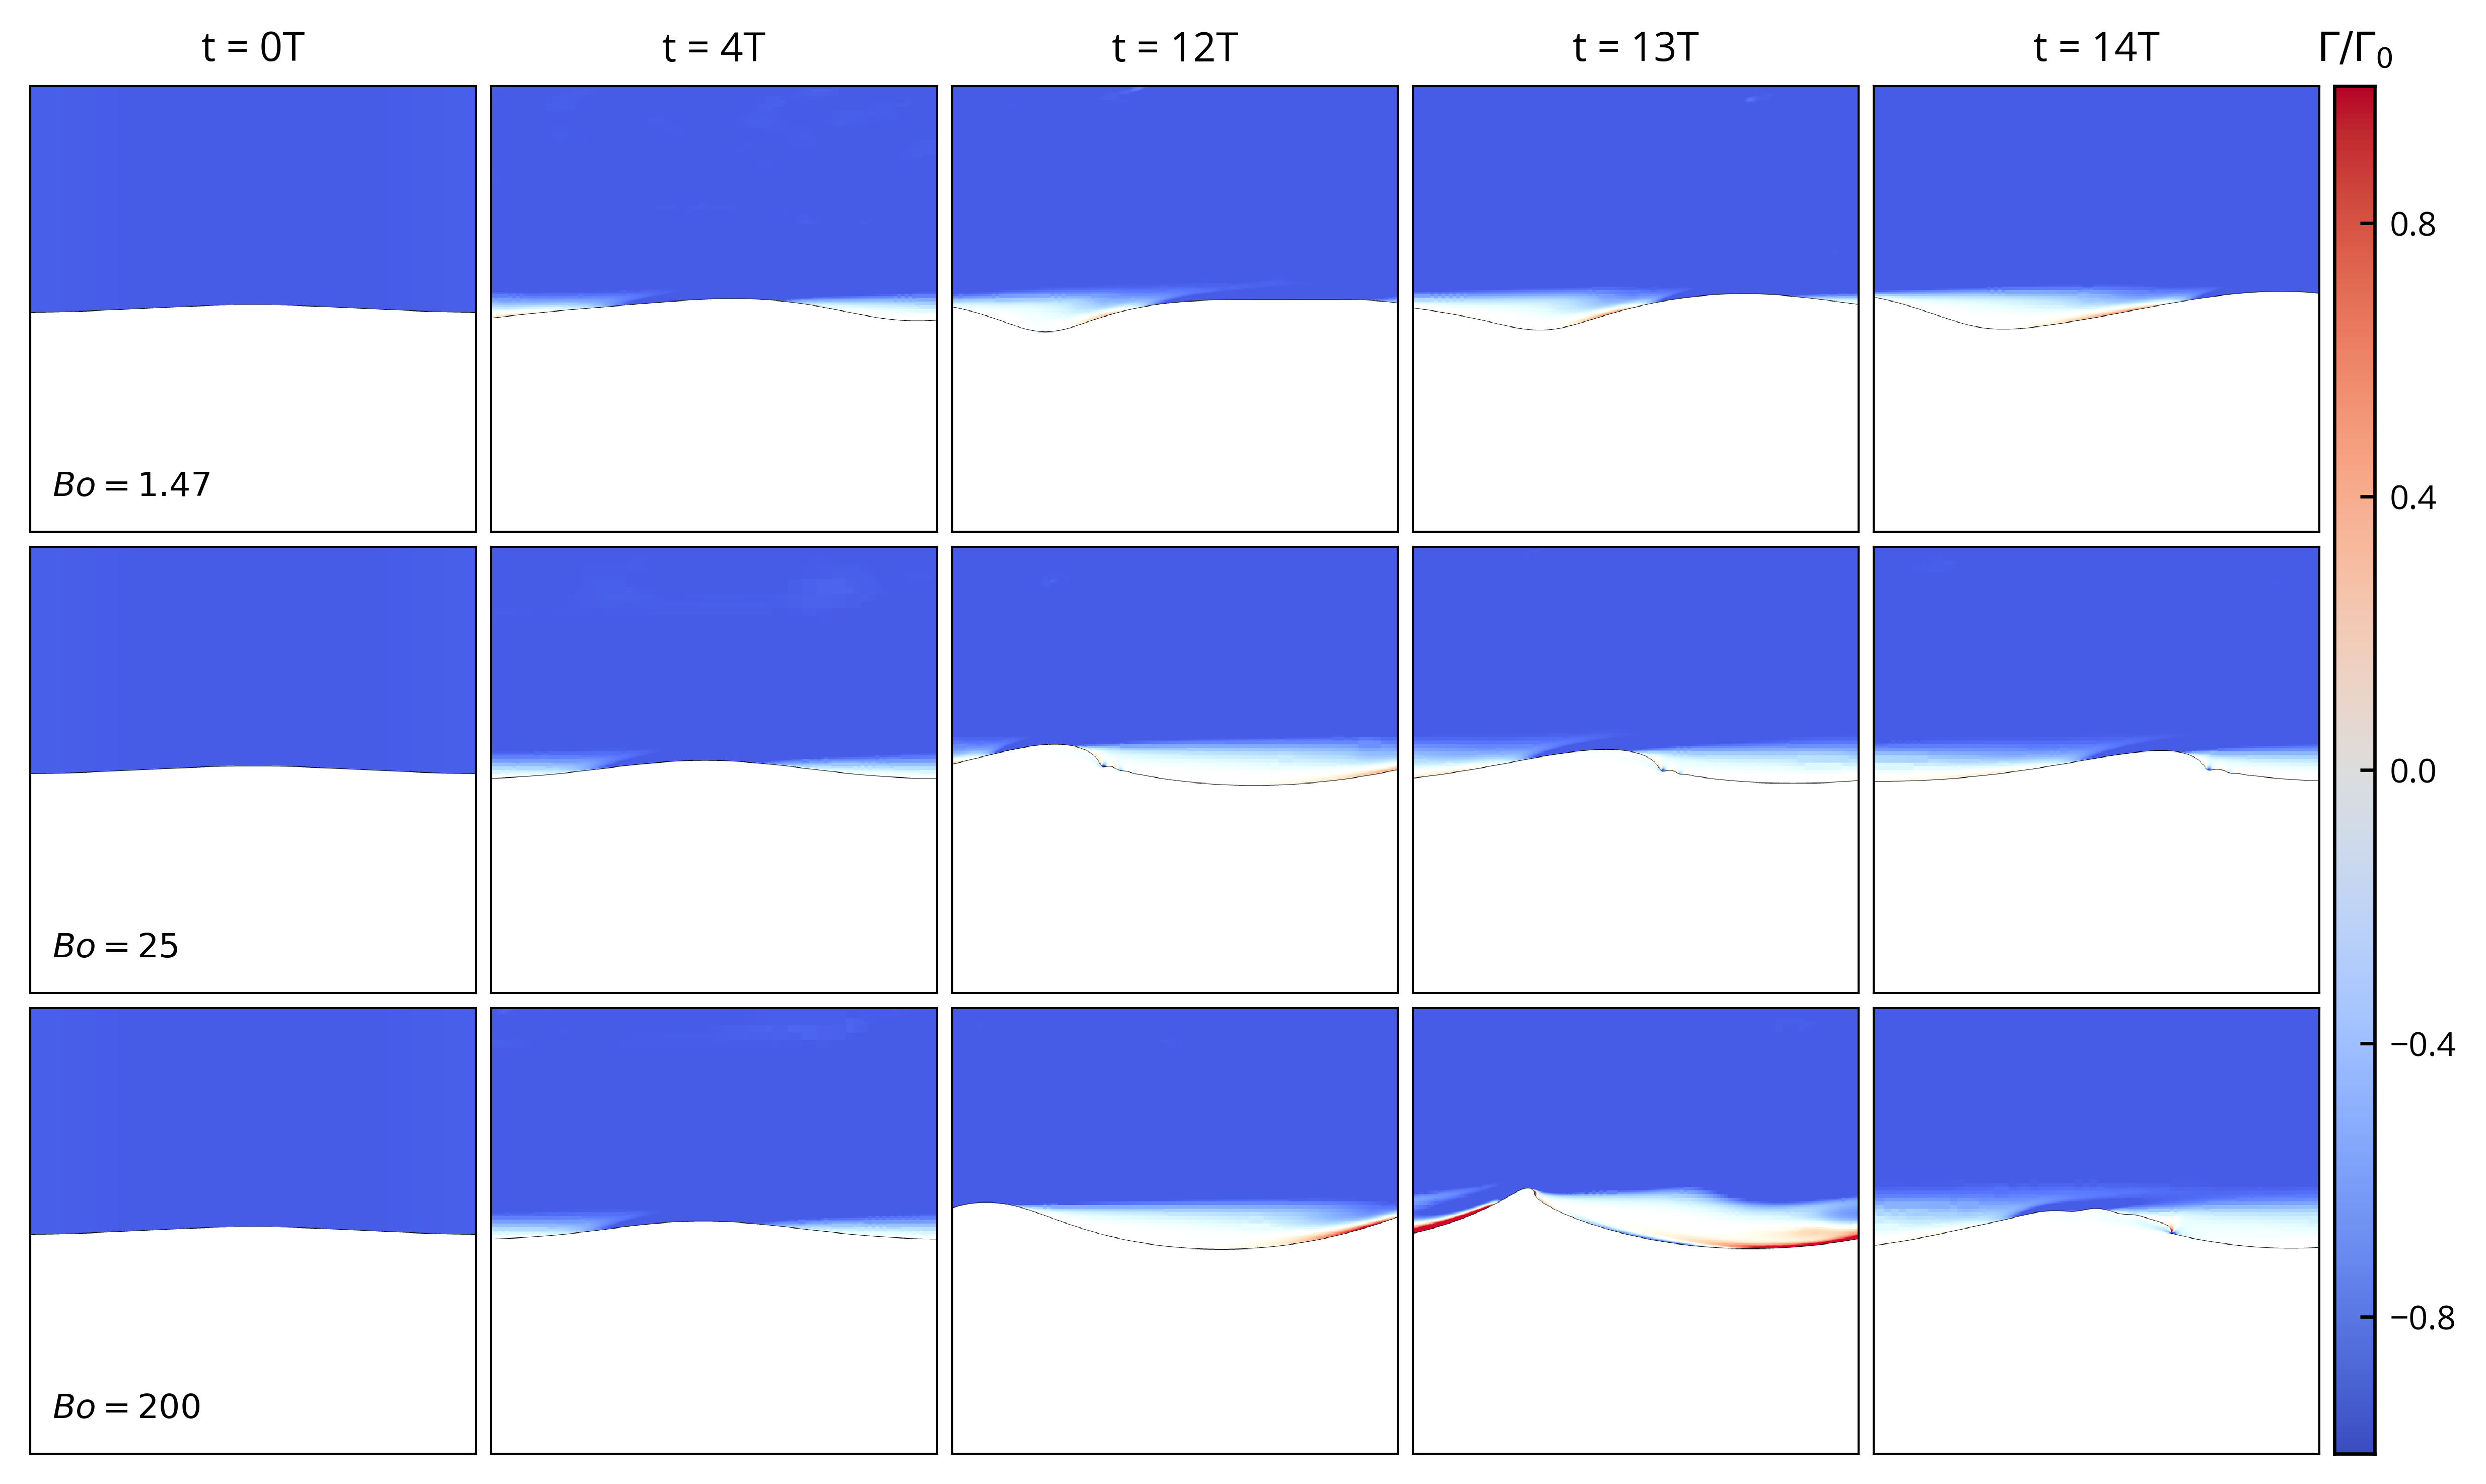

In [6]:
""" Sequence of omega for different Bo,
    Showing capillary wave, parasite wave and spilling breaker.
"""
fig = plt.figure(figsize=(8,6))
import matplotlib.image as mpimg
from mpl_toolkits.axes_grid1 import ImageGrid
column = 5
grid = ImageGrid(fig, 111,          # as in plt.subplot(111)
                 nrows_ncols=(3,column),
                 axes_pad=0.05,
                 share_all=True,
                 cbar_location="right",
                 cbar_mode="single",
                 cbar_size="3%",
                 cbar_pad=0.05,
                 )

snapshots = [0,4,11,12,13]
# This needs to be run to generate the colorbar correctly
img = mpimg.imread(case_Bo[2].path+'/movies/omega%g.png' %4, 0)
pcontour = grid[14].imshow(img, extent=[-1/2,1/2,-1/2,1/2], 
                           vmax=1, vmin=-1, cmap='coolwarm') 

for i,t in enumerate(snapshots):
    # Air vorticity
    img = mpimg.imread(case_Bo[2].path+'/movies/omega%g.png' %t, 0)
    grid[i].imshow(img)
#     grid[i].axis('off')
    grid[i].set_xticks([]); grid[i].set_yticks([])
    grid[i].set_title('t = %gT' %t)
grid[2].set_title('t = %gT' %12) # Actually cheating because it's only run till 13
grid[3].set_title('t = %gT' %13)
grid[4].set_title('t = %gT' %14) 

snapshots = [0,4,12,13,14]
for index, case in enumerate((case_Bo[5],case_Bo[8])):
    for i,t in enumerate(snapshots):
        # Air vorticity
        img = mpimg.imread(case.path+'/movies/omega%g.png' %t, 0)
        grid[i+(index+1)*column].imshow(img)
#         grid[i+(index+1)*colume].axis('off')
        grid[i+(index+1)*column].set_xticks([]); grid[i+(index+1)*column].set_yticks([]);
    
grid[0].text(0.05,0.1, r'$Bo=%g$' %case_Bo[2].Bo, ha='left', va='center', transform=grid[0].transAxes)
grid[5].text(0.05,0.1, r'$Bo=%g$' %case_Bo[5].Bo, ha='left', va='center', transform=grid[5].transAxes)
grid[10].text(0.05,0.1, r'$Bo=%g$' %case_Bo[8].Bo, ha='left', va='center', transform=grid[10].transAxes)
grid[14].cax.colorbar(pcontour)
grid[14].cax.set_title(r'$\Gamma/\Gamma_0$')
for g in grid:
    for axis in ['top','bottom','left','right']:
        g.spines[axis].set_linewidth(0.5)
fig.savefig(working_dir+'plots/rev_nonlinear_seq.pdf', pad_inches=0.1)

In [8]:
# Low pass filtering
from scipy.signal import butter, filtfilt
def butter_lowpass_filter(data, CUT=4):
    T = 1           # Sample Period
    fs = 2046      # Sample rate, Hz
    cutoff = CUT    # desired cutoff frequency of the filter, Hz
    nyq = 0.5 * fs  # Nyquist Frequency
    order = 2      # sin wave can be approximately represented as quadratic
    n = int(T * fs) # total number of samples
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

/home/jiarong/anaconda3/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


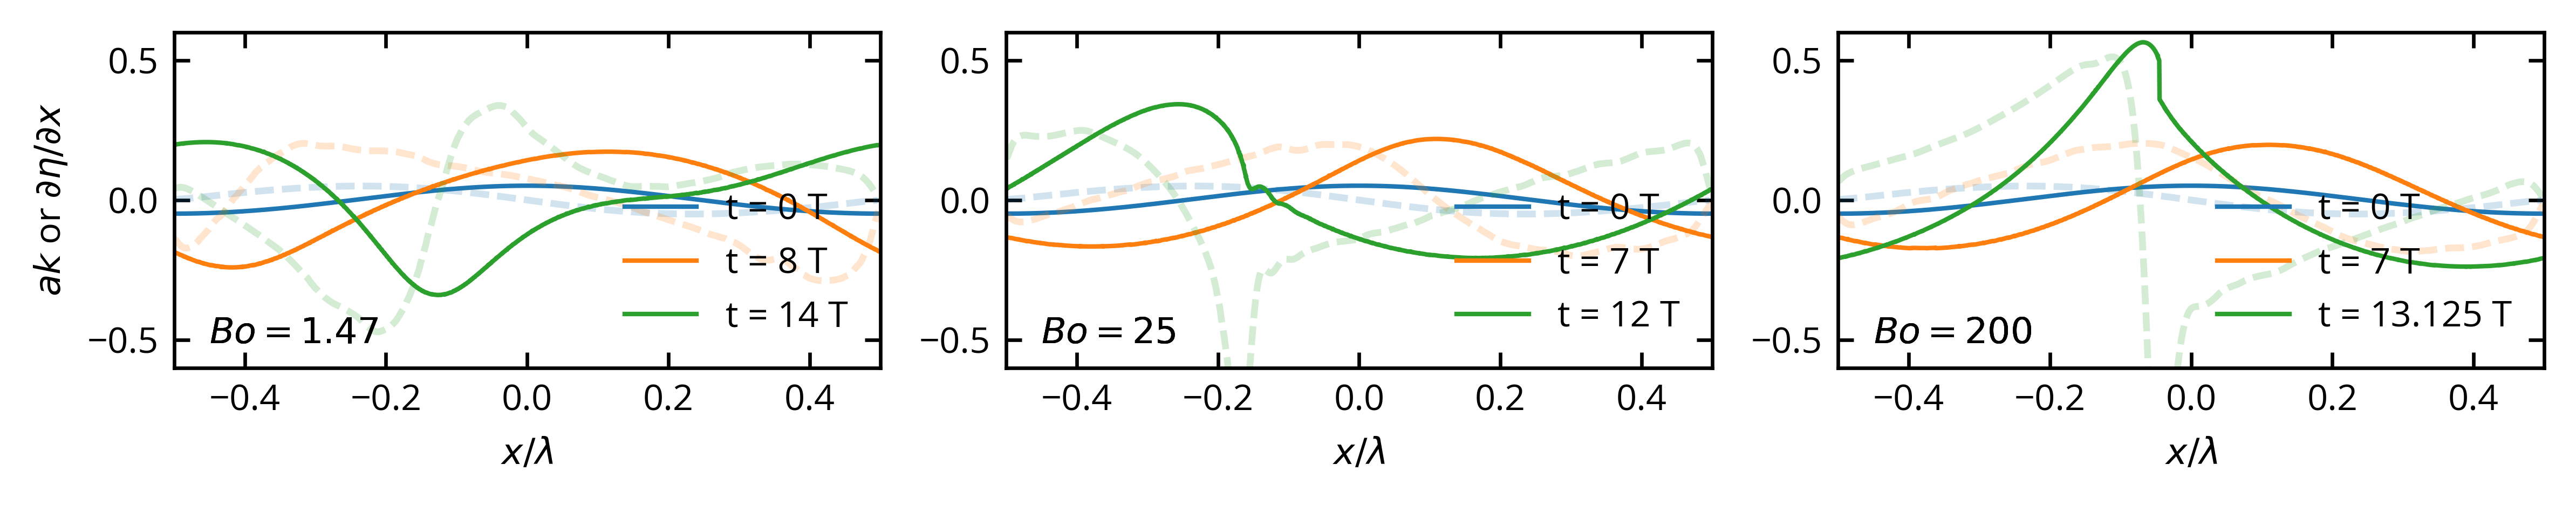

In [98]:
"""Plot the shape and slopes of nonlinear waves. """

from Amplitude import Amplitude
from fio import readin
from scipy.interpolate import BSpline
from matplotlib import gridspec

fig = plt.figure(figsize = [8,1.6])
cc = ['C0', 'C1', 'C2']
gs = gridspec.GridSpec(1,3) 
ax_ = []

# Hand pick the time
case = case_Bo[2]
ax = plt.subplot(gs[0])
ax_.append(ax)
for i, time in enumerate([0/32,256/32,14]):
    etafile = case.path + '/field/eta%.7g' %time
    eta, exists = readin(etafile, table_delimiter = ',')
    if exists:
        eta.rename(columns={'pos':'eta'}, inplace=True)
    ampl = Amplitude(eta[['x', 'eta', 'f']], 128, 1) 
    x, indices = np.unique(ampl.x, return_index=True)
    eta = ampl.eta[indices]
    k = 2
    eta_ = butter_lowpass_filter(eta, CUT=16)
    ax.plot(x, eta*2*np.pi, lw = 1, c=cc[i], label = 't = %g T' %time)
#     ax.plot(x, eta_*2*np.pi, lw = 2, c=cc[i], alpha = 0.2)
    ax.plot(x[0:-1:4], np.gradient(eta_[0:-1:4])/(1/np.size(eta_[0:-1:4])), '--', c=cc[i], alpha = 0.2)
    ax.set_ylim([-0.6,0.6]); ax.set_xlim([-0.5,0.5])
    ax.text(0.05,0.1, r'$Bo=%g$' %case.Bo, ha='left', va='center', transform=ax.transAxes)
    
case = case_Bo[5]
ax = plt.subplot(gs[1])
ax_.append(ax)
for i, time in enumerate([0/32,224/32,12]):
    etafile = case.path + '/field/eta%.7g' %time
    eta, exists = readin(etafile, table_delimiter = ',')
    if exists:
        eta.rename(columns={'pos':'eta'}, inplace=True)
    ampl = Amplitude(eta[['x', 'eta', 'f']], 128, 1) 
    x, indices = np.unique(ampl.x, return_index=True)
    eta = ampl.eta[indices]
    k = 2
    eta_ = butter_lowpass_filter(eta, CUT=16)
    ax.plot(x, eta*2*np.pi, lw = 1, c=cc[i], label = 't = %g T' %time)
#     ax.plot(x, eta_*2*np.pi, lw = 2, c=cc[i], alpha = 0.2)
    ax.plot(x[0:-1:4], np.gradient(eta_[0:-1:4])/(1/np.size(eta_[0:-1:4])), '--', c=cc[i], alpha = 0.2)
    ax.set_ylim([-0.6,0.6]); ax.set_xlim([-0.5,0.5])
    ax.text(0.05,0.1, r'$Bo=%g$' %case.Bo, ha='left', va='center', transform=ax.transAxes)

case = case_Bo[8]
ax = plt.subplot(gs[2])
ax_.append(ax)
for i, time in enumerate([0/32,224/32,420/32]):
    etafile = case.path + '/field/eta%.7g' %time
    eta, exists = readin(etafile, table_delimiter = ',')
    if exists:
        eta.rename(columns={'pos':'eta'}, inplace=True)
    ampl = Amplitude(eta[['x', 'eta', 'f']], 128, 1) 
    x, indices = np.unique(ampl.x, return_index=True)
    eta = ampl.eta[indices]
    k = 2
    eta_ = butter_lowpass_filter(eta, CUT=16)
    ax.plot(x, eta*2*np.pi, lw = 1, c=cc[i], label = 't = %g T' %time)
#     ax.plot(x, eta_*2*np.pi, lw = 2, c=cc[i], alpha = 0.2)
    ax.plot(x[0:-1:4], np.gradient(eta_[0:-1:4])/(1/np.size(eta_[0:-1:4])), '--', c=cc[i], alpha = 0.2)
    ax.set_ylim([-0.6,0.6]); ax.set_xlim([-0.5,0.5])
    ax.text(0.05,0.1, r'$Bo=%g$' %case.Bo, ha='left', va='center', transform=ax.transAxes)

ax_[0].set_xlabel(r'$x/\lambda$'); 
ax_[1].set_xlabel(r'$x/\lambda$');
ax_[2].set_xlabel(r'$x/\lambda$');
ax_[0].set_ylabel(r'$ak$ or $\partial \eta/\partial x$')
ax_[2].legend(loc = 'lower right'); 
ax_[1].legend(loc = 'lower right');
ax_[0].legend(loc = 'lower right'); 
fig.savefig(working_dir+'plots/rev_slope_3Bo_different_alternative.pdf', bbox_inches='tight', pad_inches=0.1)

In [79]:
12*32

384

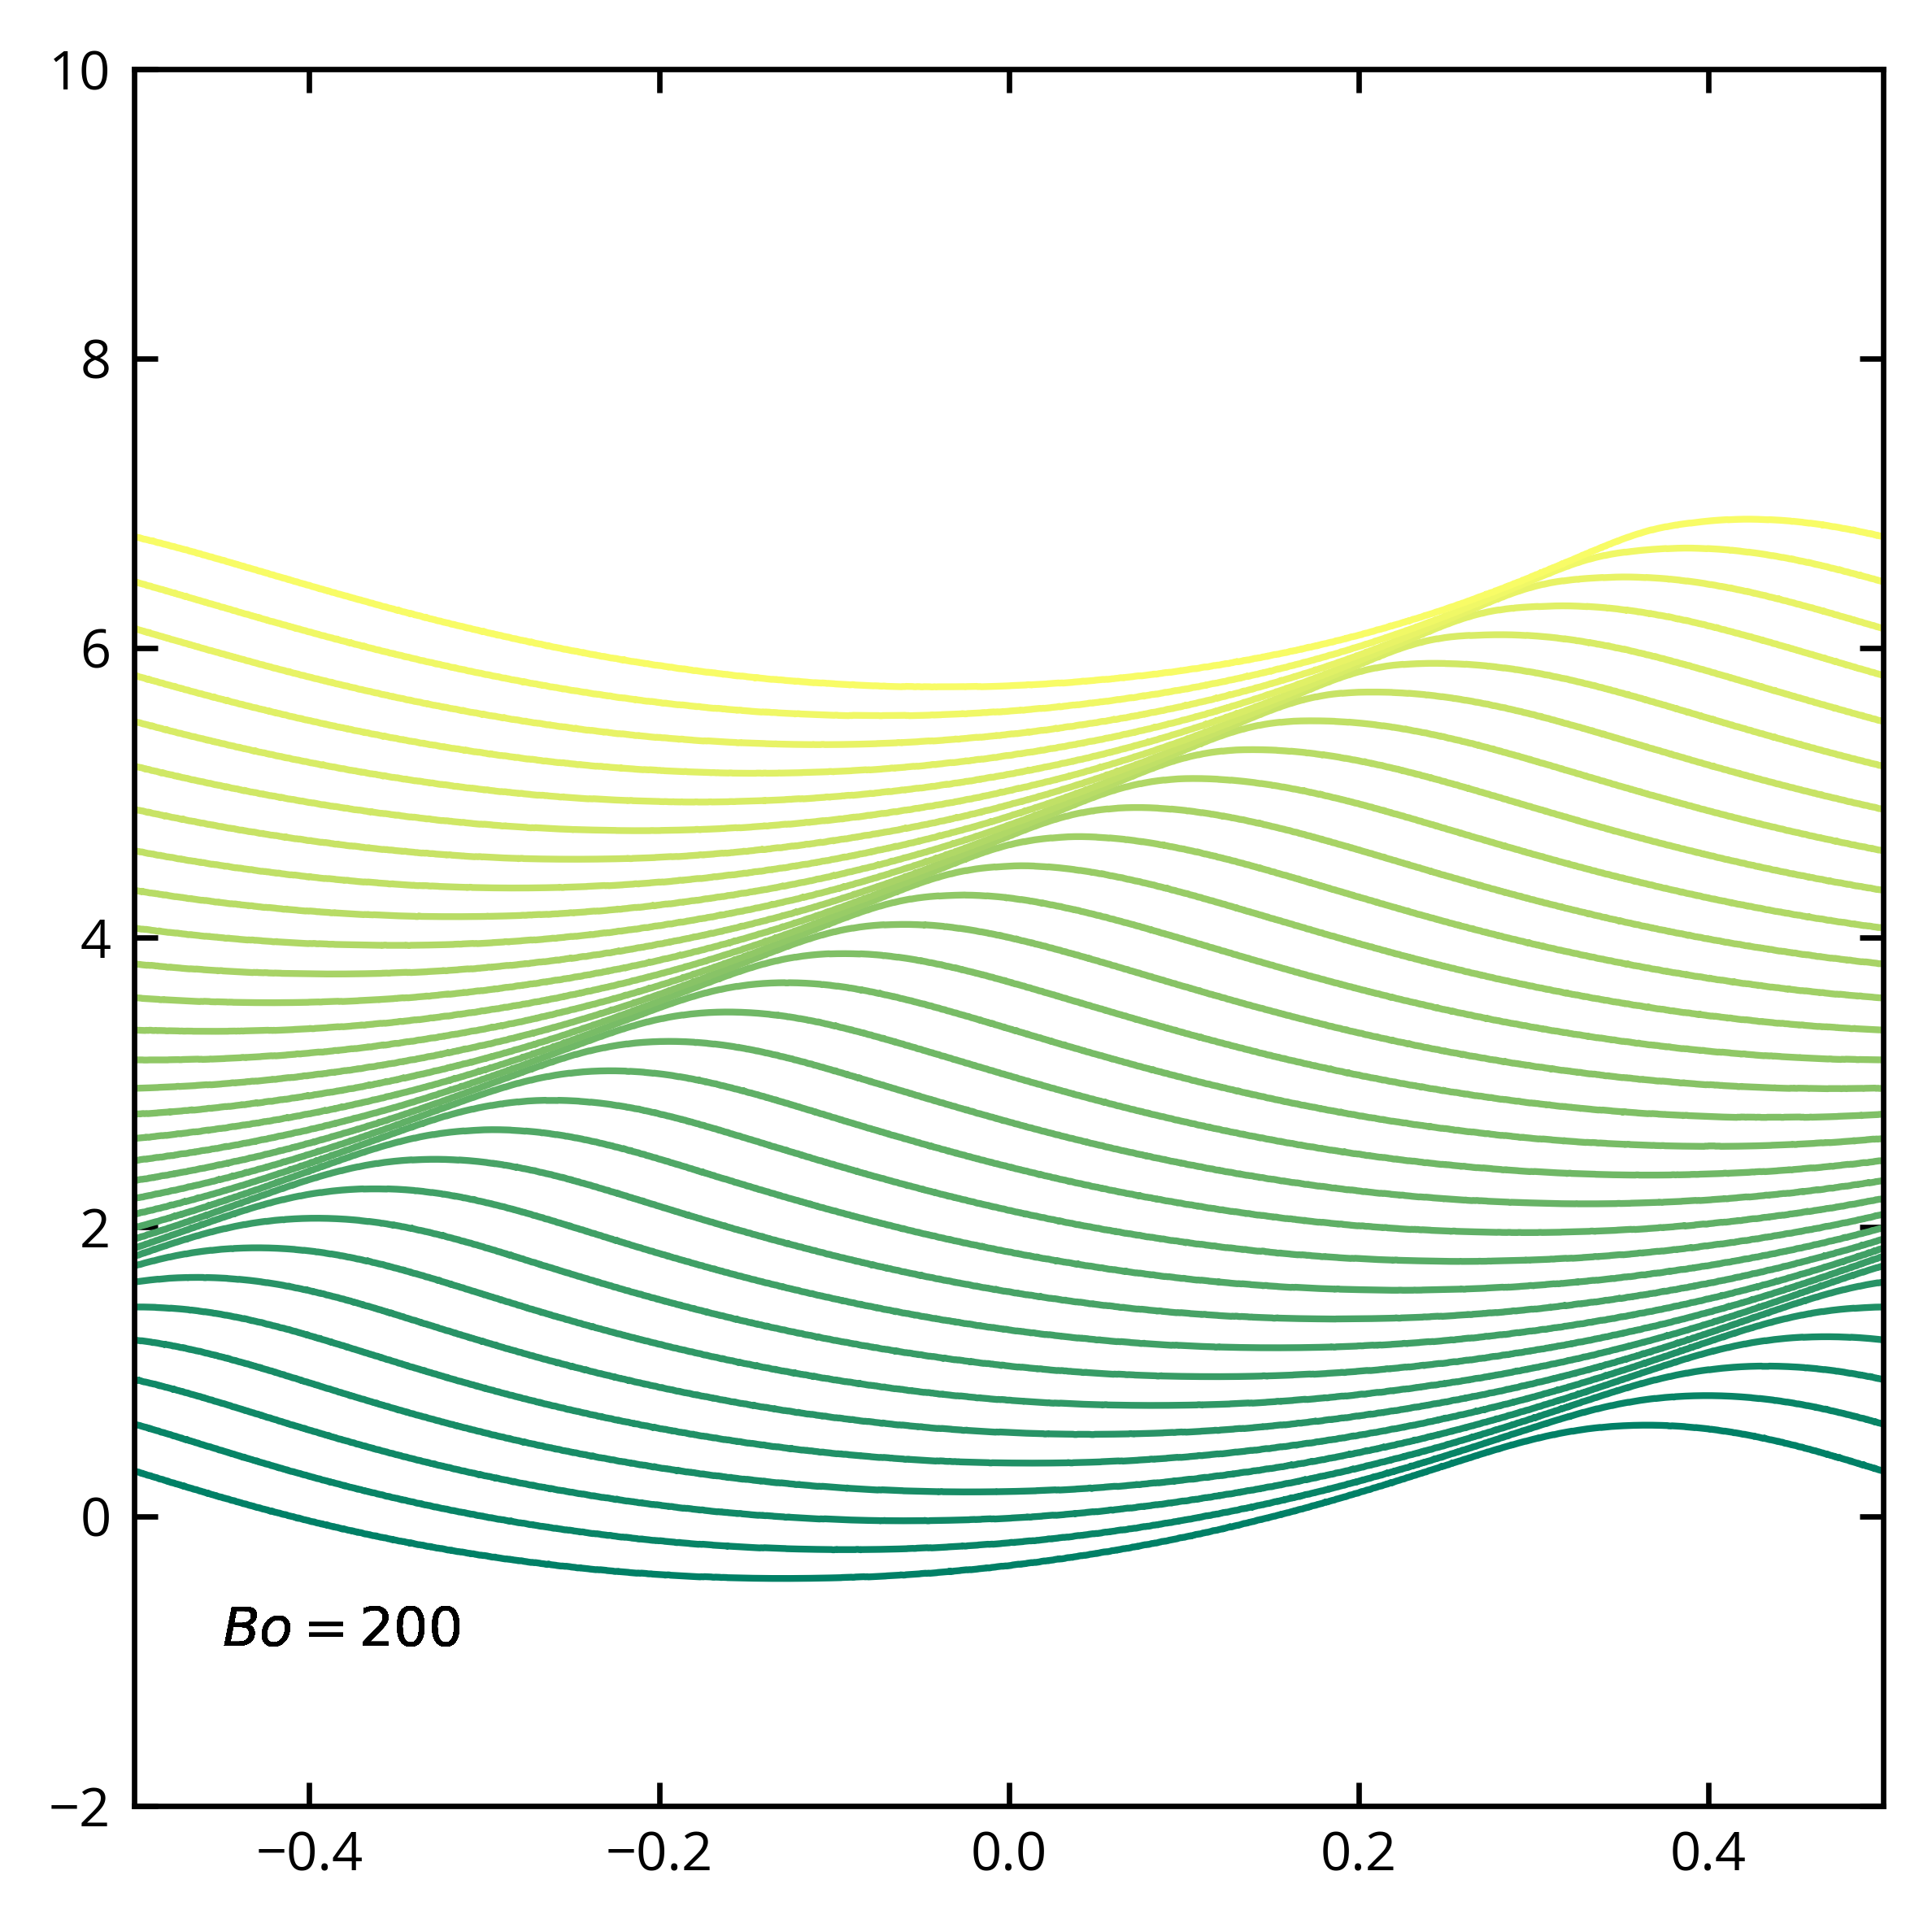

In [69]:
fig = plt.figure(figsize = [4,4]); ax = plt.gca()
cc = ['C0', 'C1', 'C2']
case = case_Bo[8]
time_ = np.arange(320,352)/32
for i, time in enumerate(time_):
    etafile = case.path + '/field/eta%.7g' %time
    eta, exists = readin(etafile, table_delimiter = ',')
    if exists:
        eta.rename(columns={'pos':'eta'}, inplace=True)
    ampl = Amplitude(eta[['x', 'eta', 'f']], 128, 1) 
    x, indices = np.unique(ampl.x, return_index=True)
    eta = ampl.eta[indices]
    k = 2
    if (j == 1) & (time == 384/32):
        eta_ = butter_lowpass_filter(eta, CUT=64)
    else:
        eta_ = butter_lowpass_filter(eta, CUT=8)
    ax.plot(x, eta*2*np.pi*2 + i*0.2, lw = 1, c=plt.cm.get_cmap('summer')(i/32), label = 't = %g T' %time)
#     grad = np.gradient(eta_)/(1/np.size(eta_))
#     grad_smooth = butter_lowpass_filter(grad, CUT=32)
#     ax.plot(x, grad, '--', c=cc[i], alpha = 0.2)
    ax.set_xlim([-0.5,0.5]); ax.set_ylim([-2,10])
    ax.text(0.05,0.1, r'$Bo=%g$' %case.Bo, ha='left', va='center', transform=ax.transAxes)


### Energy curve and growth rate

In [ ]:
"""Compute energy growth rate."""
for case in case_Bo:
    print('Bo = %g, u*/c = %g' %(case.Bo, case.ustar))
    eta1,eta2,spectrum1,spectrum2 = case.spectrum_filtering(N_time = 96, N_padding = 9, WINDOW = True)
    case.growth_rate_notfiltered(96, CAPI=True)
    case.wa_nonfilter,case.wb_nonfilter = np.polyfit(case.t[1:96], np.log(case.energy_wave[1:96]), 1)
    print('Not filtered: %g' %case.wa_nonfilter)
    case.growth_rate(96, CAPI=True)
    print('Filtered: %g' %case.wa)

0.5613164532440789
0.4336436076380099
0.4261141093353861


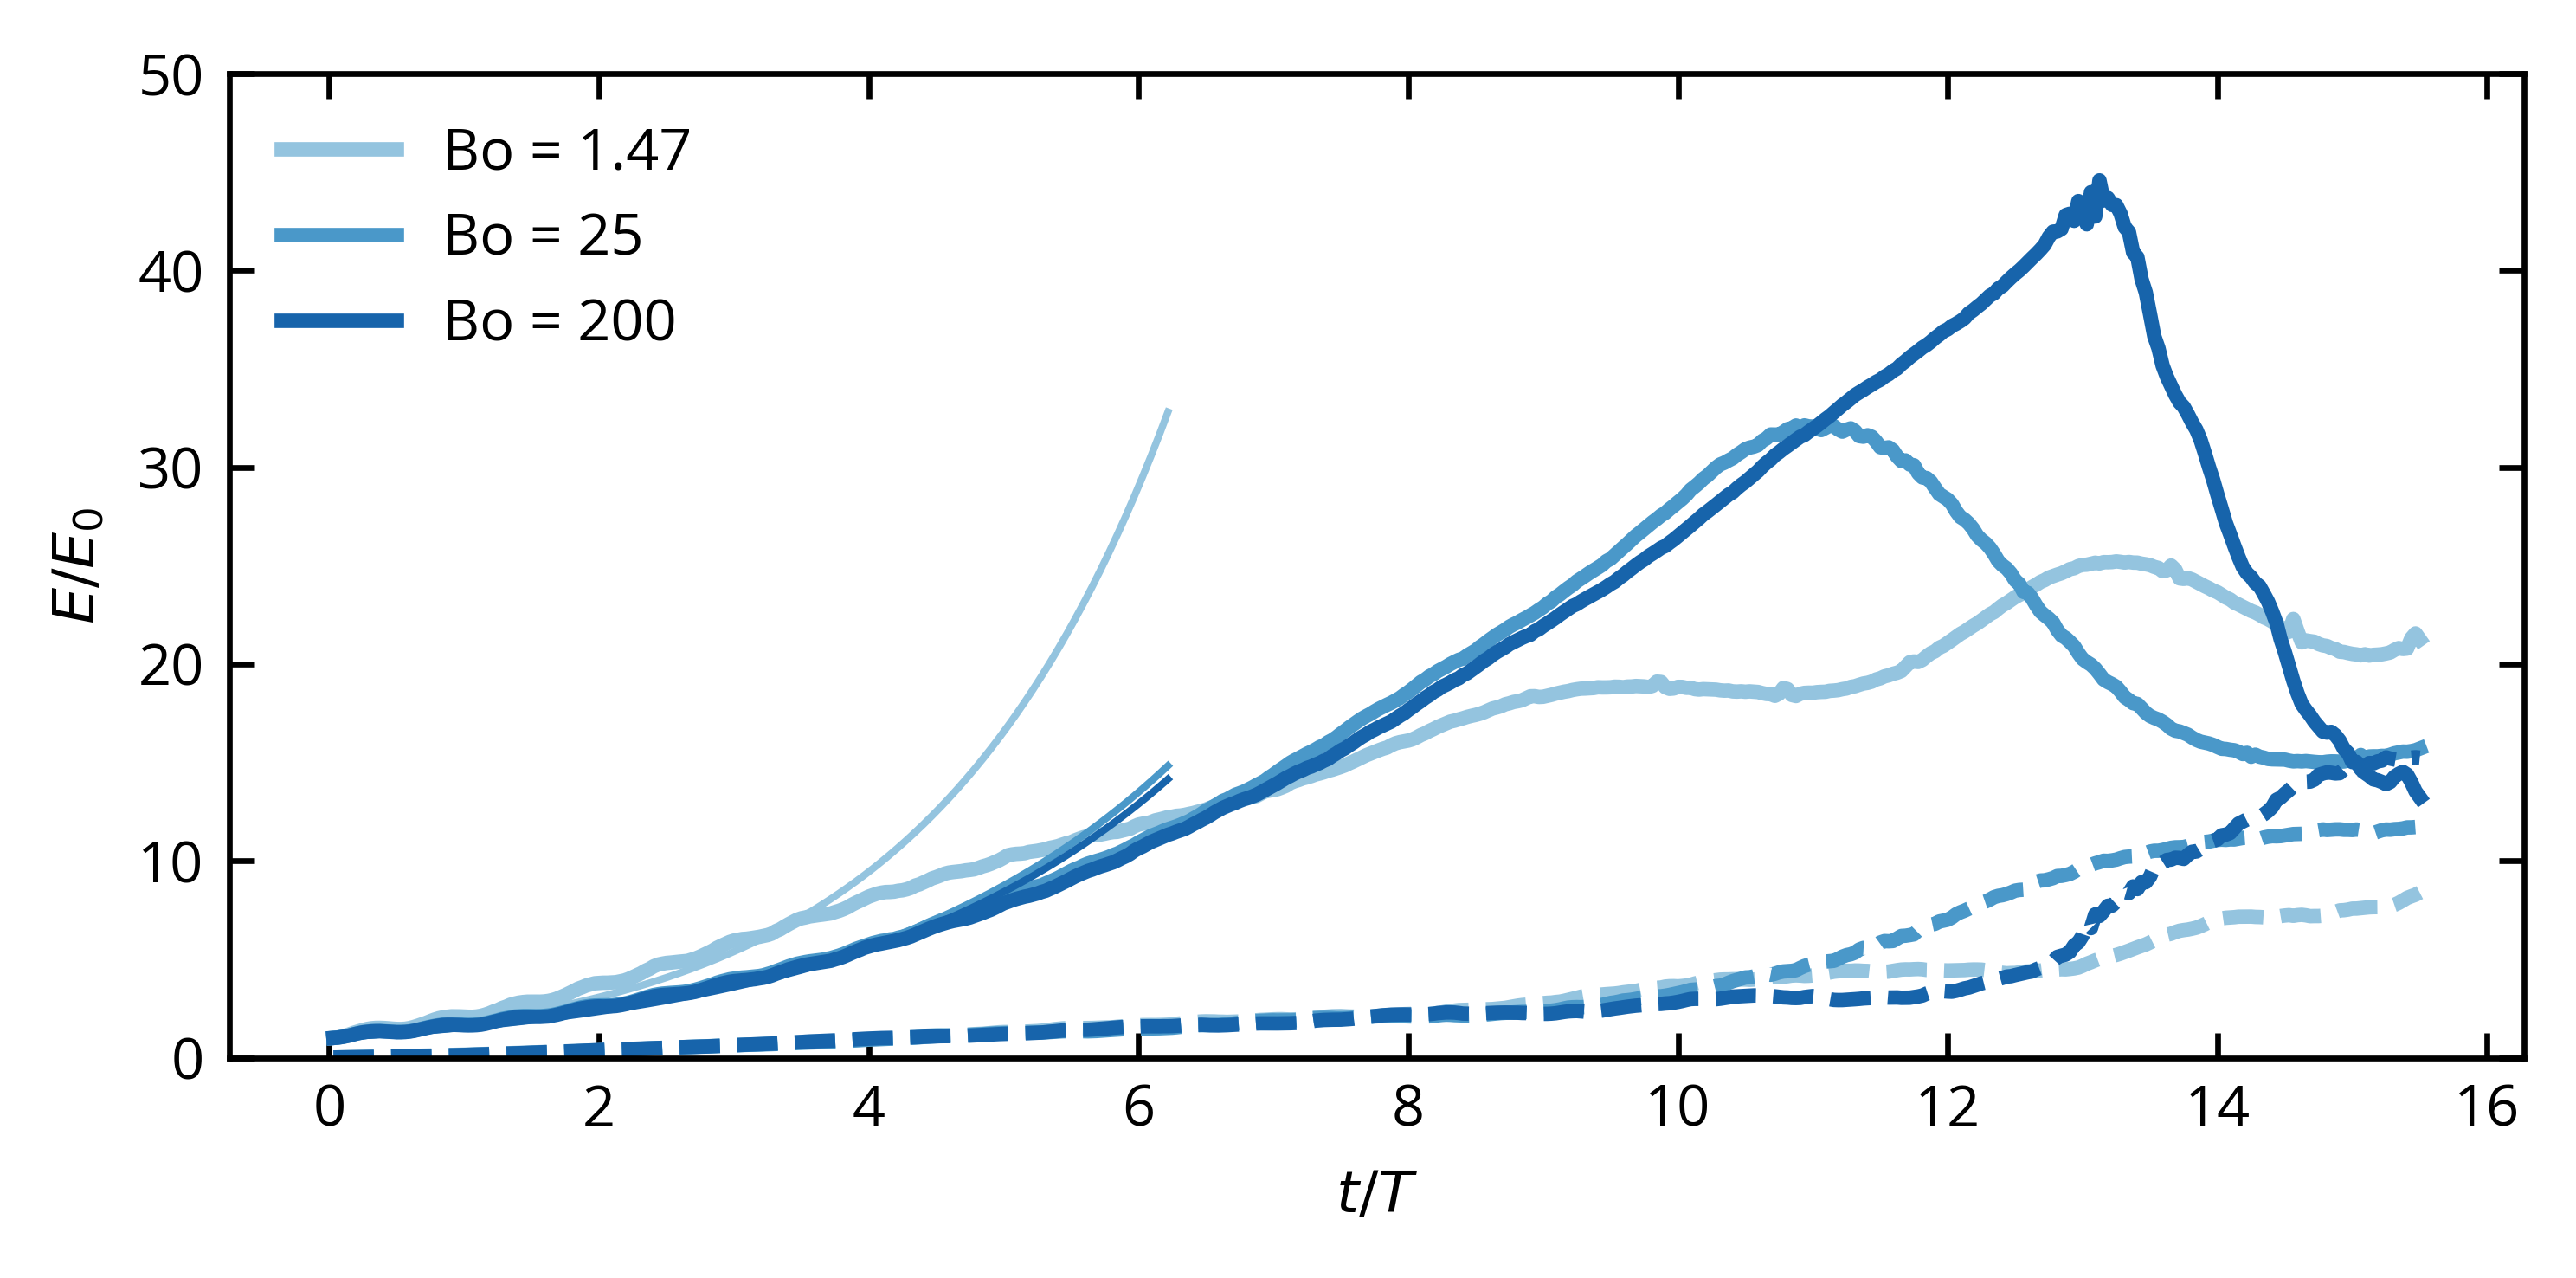

In [103]:
""" For revision. Plot different Bo. """
fig = plt.figure(figsize=[5,2.5])
ax1 = plt.gca()
color = ['C0', 'C1', 'C2', 'C3']
case_ensem = [case_Bo[2], case_Bo[5], case_Bo[8]]

eta1,eta2,spectrum1,spectrum2 = case_Bo[2].spectrum_filtering(N_time = 500, N_padding = 9, WINDOW = True)
case_Bo[2].growth_rate_notfiltered(500, CAPI=True)
eta1,eta2,spectrum1,spectrum2 = case_Bo[5].spectrum_filtering(N_time = 500, N_padding = 9, WINDOW = True)
case_Bo[5].growth_rate_notfiltered(500, CAPI=True)
eta1,eta2,spectrum1,spectrum2 = case_Bo[8].spectrum_filtering(N_time = 500, N_padding = 9, WINDOW = True)
case_Bo[8].growth_rate_notfiltered(500, CAPI=True)

cmap = 'Blues'
for i,case in enumerate(case_ensem):
    case.t = np.arange(np.size(case.energy_wave))/32
    ax1.plot(case.t[1:-3],case.energy_wave[1:-3]/case.energy_wave[1], '-', label=r'Bo = %g' %case.Bo, 
            color=plt.get_cmap(cmap)((i+2)/5), lw = 2)
    ax1.plot(case.t[1:-3],case.ke_drift[1:-3]/case.energy_wave[1], '--', 
            color=plt.get_cmap(cmap)((i+2)/5), lw = 2)

#     ke_drift = butter_lowpass_filter(case.ke_drift, CUT=0.5)
#     energy_wave = butter_lowpass_filter(case.energy_wave, CUT=0.5)

    # Fit the filtered curve
    wa,wb = np.polyfit(case.t[1:96], np.log(case.energy_wave[1:96]), 1)
    print(wa)
    ax1.plot(case.t[1:200],np.exp(case.t[1:200]*wa), alpha = 1, 
             color=plt.get_cmap(cmap)((i+2)/5), lw = 1)   

    ax1.set_ylim([0,50])
    ax1.set_ylabel(r'$E/E_0$')
#     formatter = ticker.ScalarFormatter(useMathText=True)
#     formatter.set_scientific(True) 
#     formatter.set_powerlimits((-1,1)) 
#     ax1.yaxis.set_major_formatter(formatter)

ax1.set_xlabel(r'$t/T$')
plt.legend()
fig.savefig(working_dir+'plots/rev_Bo_energy.pdf', pad_inches=0.1)

In [ ]:
""" A wrapper function that is basically scipy.griddata with method='linear' but will fill in the blank part with 
    values given by method='nearest'.
"""
def griddata_linear_2D (points, values, grid):
grid_z0 = griddata(points, values, (grid_x, grid_y), method='nearest')
grid_z1 = griddata(points, values, (grid_x, grid_y), method='linear')

fill_value = 123  # Whatever you like
grid_z0[np.isnan(grid_z1)] = fill_value

np.interp(self.x_interp, self._eta_data.x, self._eta_data.eta)

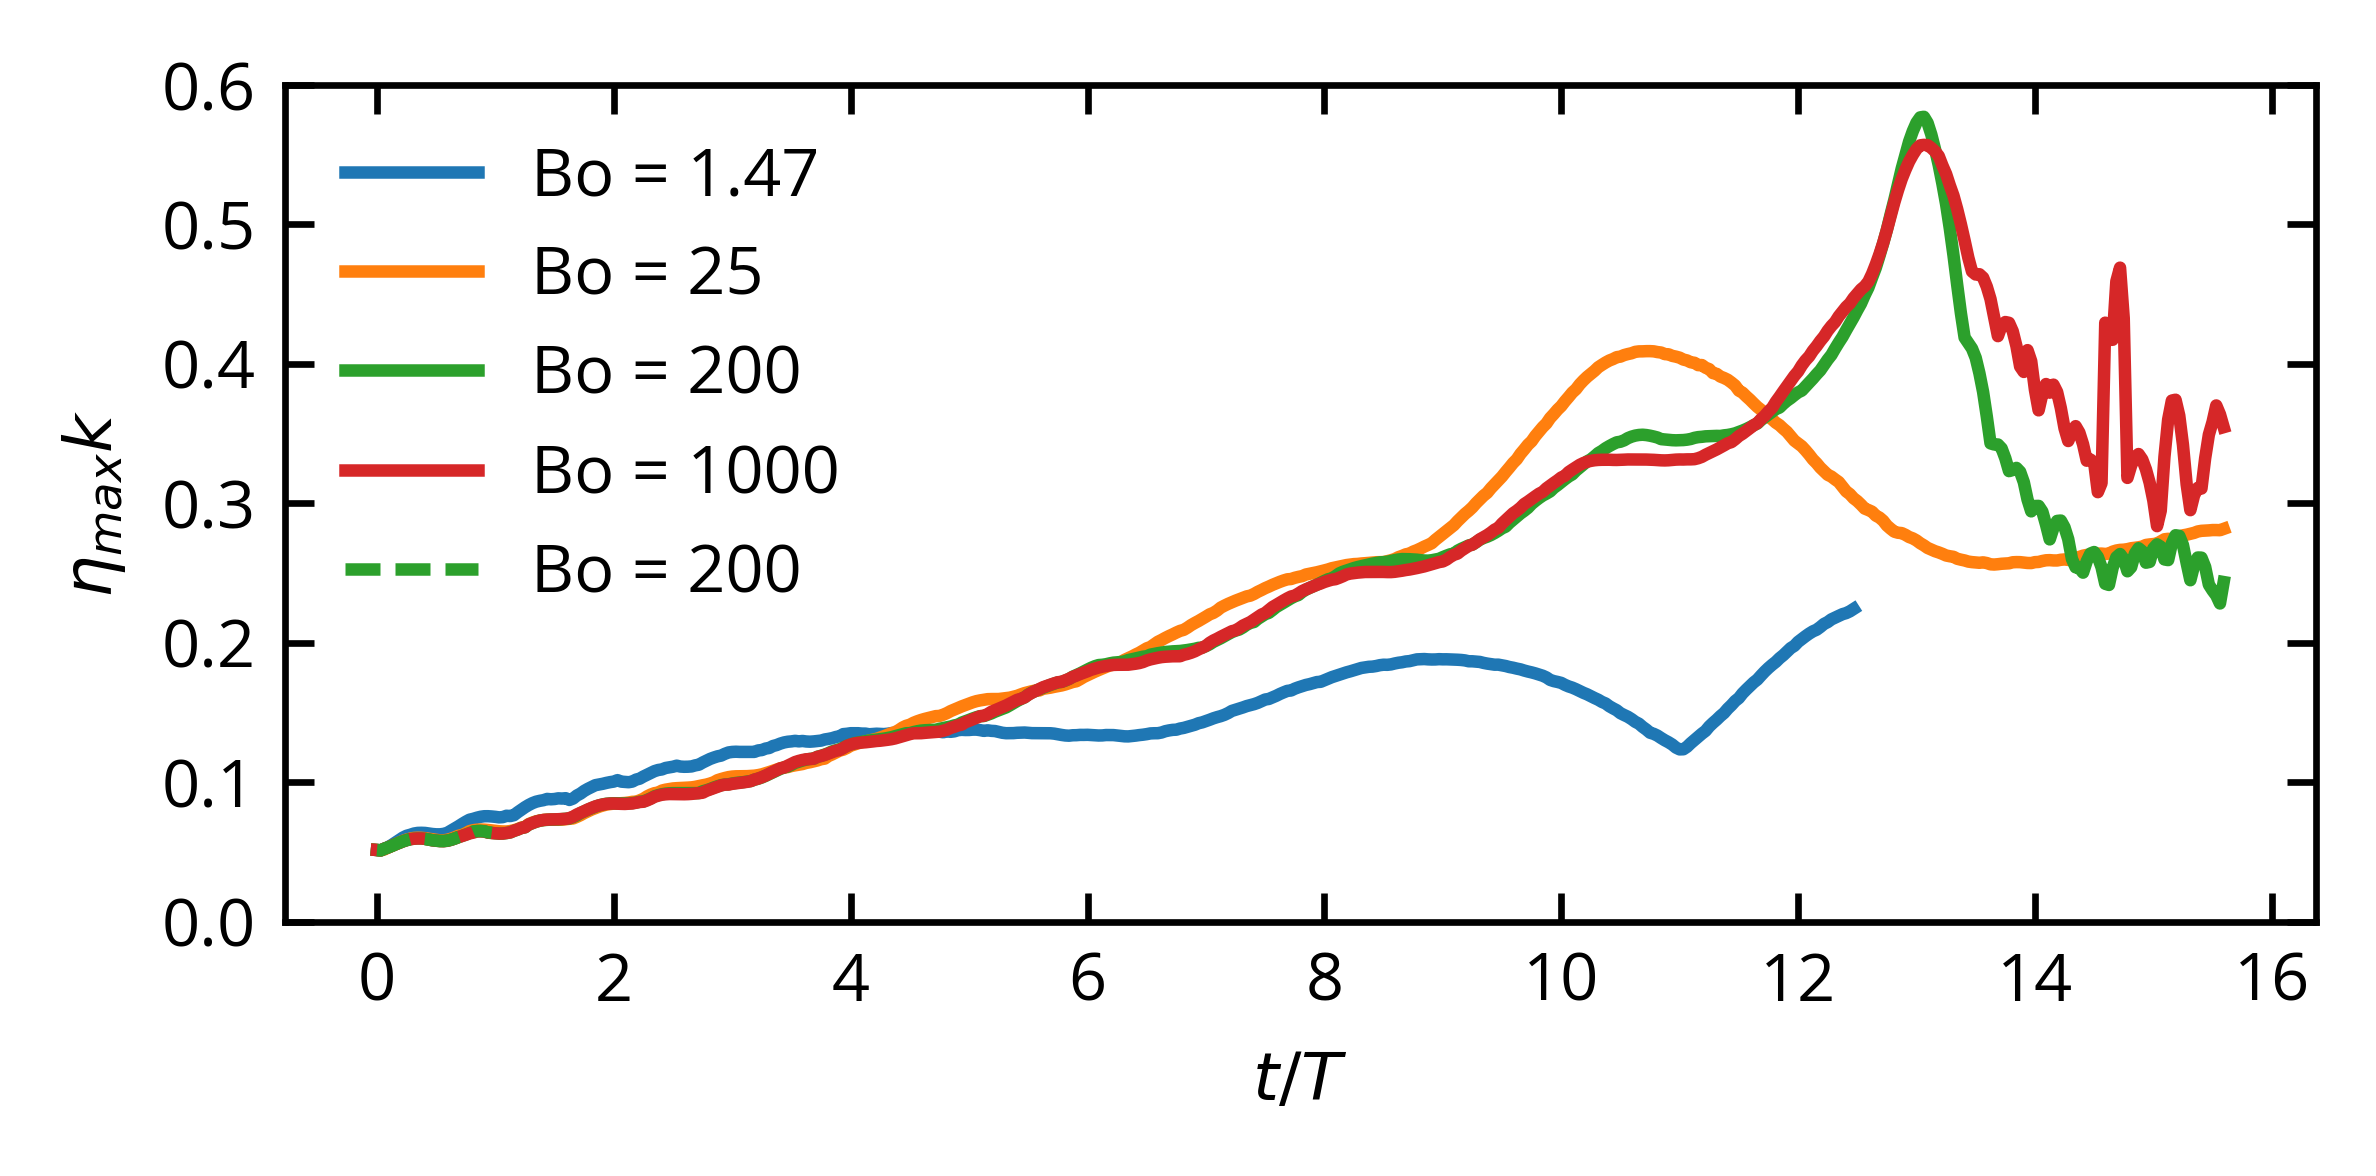

In [306]:
"""The local slope."""
fig = plt.figure(figsize = [4,2])

crest = []
case = case_Bo[2]
times = np.arange(0,400)/32
for i, time in enumerate(times):
    etafile = case.path + '/field/eta%.7g' %time
    eta, exists = readin(etafile, table_delimiter = ',')
    if exists:
        eta.rename(columns={'pos':'eta'}, inplace=True)
    ampl = Amplitude(eta[['x', 'eta', 'f']], 64, 1) 
    x, indices = np.unique(ampl.x, return_index=True)
    eta = ampl.eta[indices]
    crest.append(eta.max())
crest = np.array(crest)
plt.plot(times, crest*2*np.pi, label = 'Bo = %g' %case.Bo)

times = np.arange(0,500)/32
for case in (case_Bo[5], case_Bo[8], case_Bo[10]):
    crest = []
    for i, time in enumerate(times):
        etafile = case.path + '/field/eta%.7g' %time
        eta, exists = readin(etafile, table_delimiter = ',')
        if exists:
            eta.rename(columns={'pos':'eta'}, inplace=True)
        ampl = Amplitude(eta[['x', 'eta', 'f']], 64, 1) 
        x, indices = np.unique(ampl.x, return_index=True)
        eta = ampl.eta[indices]
        crest.append(eta.max())
    crest = np.array(crest)
    plt.plot(times, crest*2*np.pi, label = 'Bo = %g' %case.Bo)
plt.ylabel(r'$\eta_{max}k$'); plt.xlabel(r'$t/T$')
plt.ylim([0,0.6])
plt.legend()
fig.savefig(working_dir+'plots/rev_Bo_slope.eps', pad_inches=0.1)

times = np.arange(0,32)/32
crest = []
case = case_Bo[9]
for i, time in enumerate(times):
    etafile = case.path + '/field/eta%.7g' %time
    eta, exists = readin(etafile, table_delimiter = ',')
    if exists:
        eta.rename(columns={'pos':'eta'}, inplace=True)
    ampl = Amplitude(eta[['x', 'eta', 'f']], 64, 1) 
    x, indices = np.unique(ampl.x, return_index=True)
    eta = ampl.eta[indices]
    crest.append(eta.max())
crest = np.array(crest)
plt.plot(times, crest*2*np.pi, '--', label = 'Bo = %g' %case.Bo, c = 'C2')
plt.ylabel(r'$\eta_{max}k$'); plt.xlabel(r'$t/T$')
plt.ylim([0,0.6])
plt.legend()
fig.savefig(working_dir+'plots/rev_Bo_slope.eps', pad_inches=0.1)

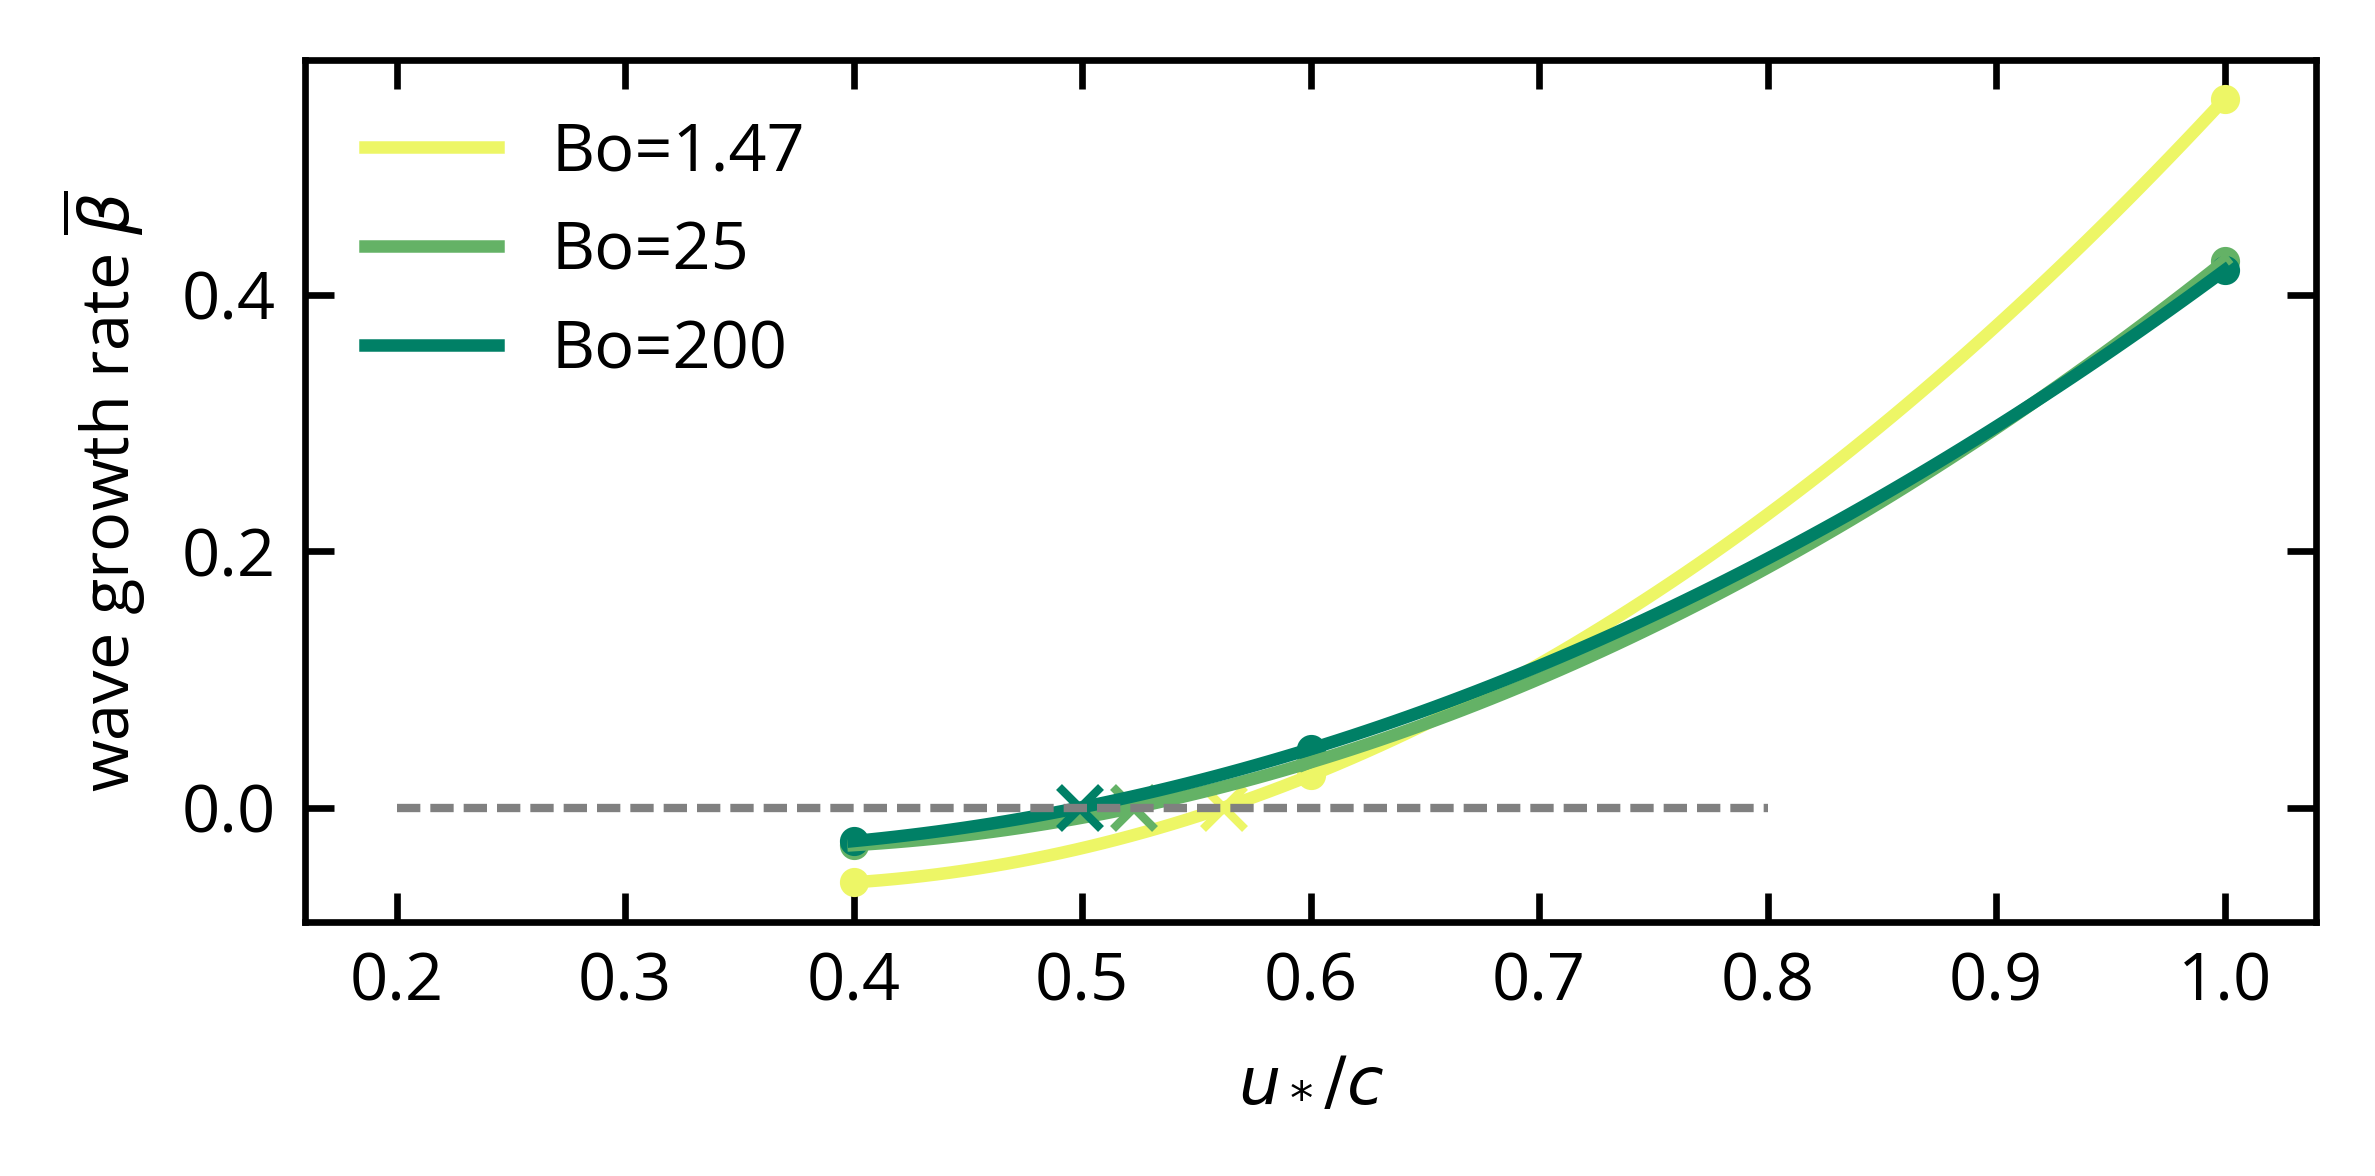

In [13]:
""" This plot has been emerged with the big one. """

plt.figure(figsize=[4,2])
dict1 = {"Bo":1.47, "ustar":[], "rate":[], "rate_nonfilter":[], "omega":case_Bo[0].wave.omega, "k":case_Bo[0].wave.k}
dict2 = {"Bo":25, "ustar":[], "rate":[], "rate_nonfilter":[], "omega":case_Bo[3].wave.omega, "k":case_Bo[3].wave.k}
dict3 = {"Bo":200, "ustar":[], "rate":[], "rate_nonfilter":[], "omega":case_Bo[6].wave.omega, "k":case_Bo[6].wave.k}
dict_ensemble = [dict1,dict2,dict3]

for BOdict in dict_ensemble:
    for case in case_Bo:
        if case.Bo == BOdict["Bo"]:
            plt.plot(case.ustar, case.wa, '.',
                     color=plt.cm.get_cmap('summer')(1-np.log(case.Bo)/np.log(200)))
            BOdict["ustar"].append(case.ustar); BOdict["rate"].append(case.wa) 
            BOdict["rate_nonfilter"].append(case.wa_nonfilter)
            
for BOdict in dict_ensemble:
    ustar = np.array(BOdict["ustar"]); rate = np.array(BOdict["rate"])
    z = np.polyfit(ustar, rate, 2); p = np.poly1d(z)
    ustar_plot = np.linspace(ustar[0],ustar[-1], 100, endpoint=True)
    plt.plot(ustar_plot,p(ustar_plot), color=plt.cm.get_cmap('summer')(1-np.log(BOdict["Bo"])/np.log(200)), 
             label='Bo=%g' %BOdict["Bo"])
    BOdict["thres"] = np.max(np.roots(p))
    plt.plot(BOdict["thres"], 0, 'x', color=plt.cm.get_cmap('summer')(1-np.log(BOdict["Bo"])/np.log(200)))
    
plt.ylabel(r'wave growth rate $\overline{\beta}$')
plt.xlabel(r'$u_*/c$')
ustar_plot = np.linspace(0.2,0.8,100)
plt.plot(ustar_plot,np.zeros(ustar_plot.shape),'--',color='gray',linewidth=1)
plt.legend()
plt.tight_layout()

In [ ]:
"""After subtracting the threshold? Not sure."""
plt.figure(figsize=[4,2])
for BOdict in dict_ensemble:
    for case in case_Bo:
        if case.Bo == BOdict["Bo"]:
            plt.plot(case.ustar - BOdict["thres"], case.wa, '.',
                     color=plt.cm.get_cmap('summer')(1-np.log(case.Bo)/np.log(200)))
            BOdict["ustar"].append(case.ustar); BOdict["rate"].append(case.wa) 
            BOdict["rate_nonfilter"].append(case.wa_nonfilter)

### Computing dE/dt and attempt to close the energy budget.

In [93]:
def butter_lowpass_filter_time(data, CUT=4):
    T = 3           # Sample Period
    fs = 32         # Sample rate, Hz
    cutoff = CUT    # desired cutoff frequency of the filter, Hz
    nyq = 0.5 * fs  # Nyquist Frequency
    order = 4       # sin wave can be approximately represented as quadratic
    n = int(T * fs) # total number of samples
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

In [138]:
case.da

7.08164731793058e-06

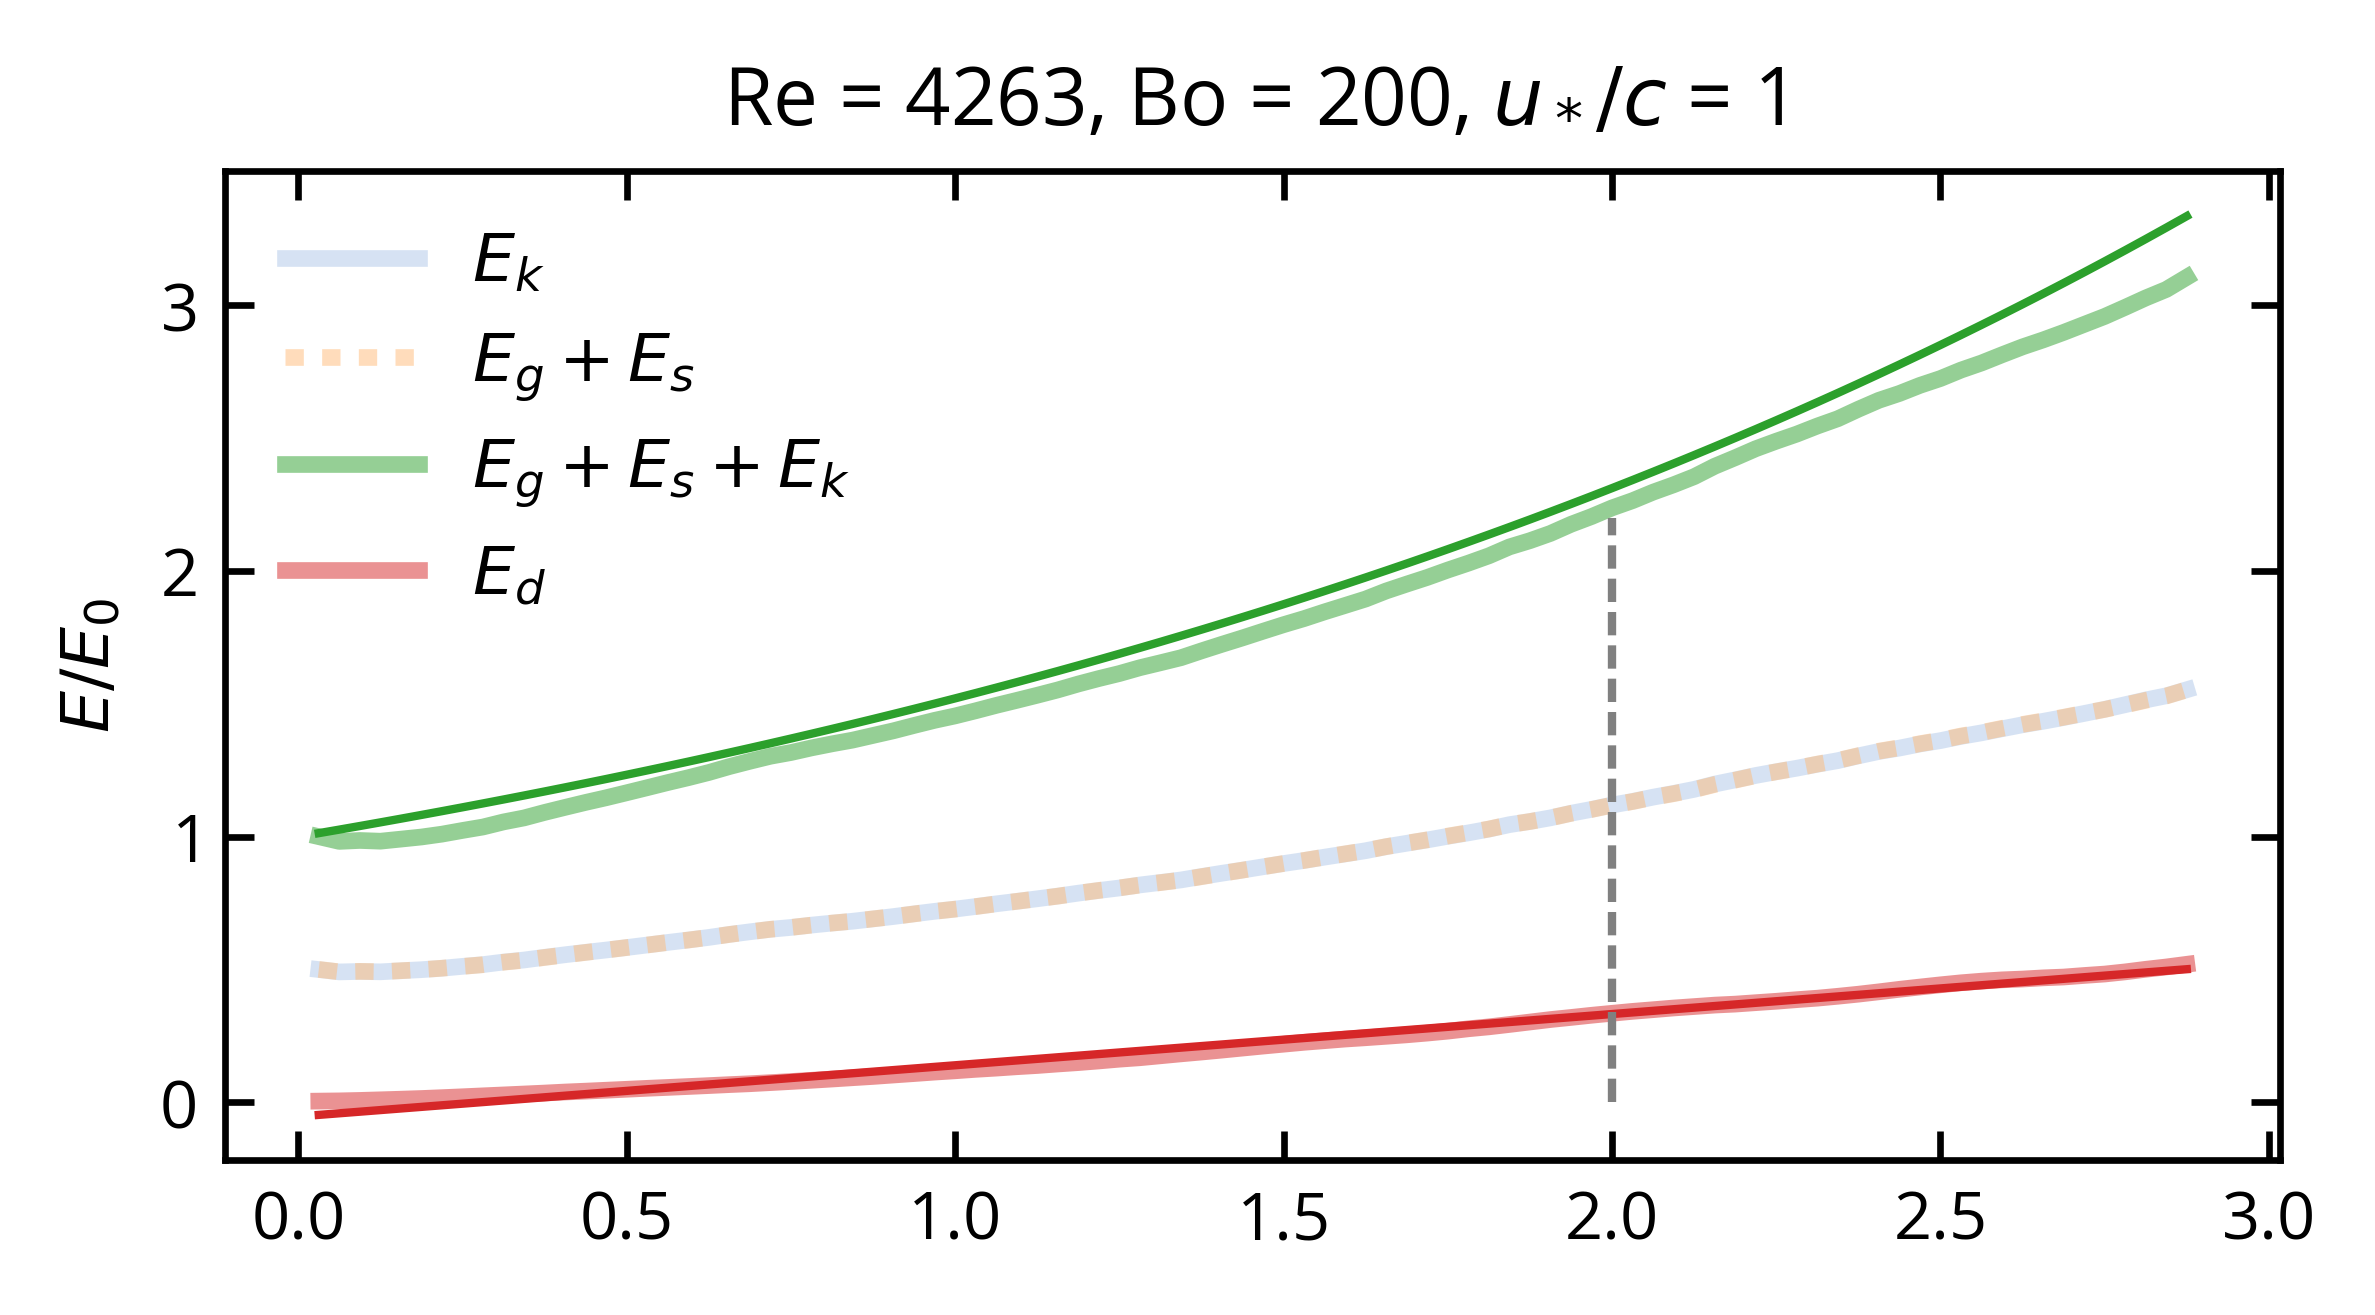

In [154]:
""" For revision. Plot drift kinetic energy too. """
case = case_Bo[8]
fig = plt.figure(figsize=[4,4])
ax1 = plt.subplot(211)
tend = 96

# eta1,eta2,spectrum1,spectrum2 = case.spectrum_filtering(N_time = 280, N_padding = 9, WINDOW = True)
# case.growth_rate_notfiltered(280, CAPI=True)

# Plot unfiltered energy (partition is not perfect)
# ax1.plot(case.t[1:tend],case.ke_wave[1:tend]/case.energy_wave[1], '-', label=r'$E_k$', 
#         color=plt.get_cmap('tab20')(1), alpha = 0.5, lw = 2)
# ax1.plot(case.t[1:tend],case.pe_wave[1:tend]/case.energy_wave[1], ':', label=r'$E_g+E_s$', 
#         color=plt.get_cmap('tab20')(3), alpha = 0.5, lw = 2)
# ax1.plot(case.t[1:tend],case.energy_wave[1:tend]/case.energy_wave[1], '-', label=r'$E_g+E_s+E_k$', 
#         color=plt.get_cmap('tab20')(4), alpha = 0.5, lw = 2)

# case.wa,case.wb = np.polyfit(case.t[1:tend], np.log(case.energy_wave[1:tend]), 1)
# print(case.wa)
# ax1.plot(case.t[1:tend],np.exp(case.t[1:tend]*case.wa), 
#          color=plt.get_cmap('tab20')(4), lw = 1) 
# ax1.plot(case.t[1:tend],case.ke_drift[1:tend]/case.energy_wave[1], label='drift KE', 
#         color=plt.get_cmap('tab20')(6), alpha = 0.5, lw = 2)
                   
# Plot filtered energy (partition is not perfect)                   
# eta1,eta2,spectrum1,spectrum2 = case.spectrum_filtering(N_time = 96, N_padding = 9, WINDOW = True)
# case.growth_rate(96, CAPI=True)
# print(case.wa)

ax1.plot(case.t[1:-3],case.ke_wave[1:-3]/case.energy_wave[1], '-', label=r'$E_k$', 
        color=plt.get_cmap('tab20')(1), alpha = 0.5, lw = 2)
ax1.plot(case.t[1:-3],case.pe_wave[1:-3]/case.energy_wave[1], ':', label=r'$E_g+E_s$', 
        color=plt.get_cmap('tab20')(3), alpha = 0.5, lw = 2)
ax1.plot(case.t[1:-3],case.energy_wave[1:-3]/case.energy_wave[1], '-', label=r'$E_g+E_s+E_k$', 
        color=plt.get_cmap('tab20')(4), alpha = 0.5, lw = 2)
ax1.plot(case.t[1:-3],np.exp(case.t[1:-3]*case.wa), 
         color=plt.get_cmap('tab20')(4), lw = 1) 
ax1.plot(case.t[1:-3],case.ke_drift[1:-3]/case.energy_wave[1], label=r'$E_d$', 
        color=plt.get_cmap('tab20')(6), alpha = 0.5, lw = 2)
ax1.plot(case.t[1:-3],(case.t[1:-3]*case.da+case.db)/case.energy_wave[1], 
        color=plt.get_cmap('tab20')(6), lw = 1)

# ax1.set_ylim([0,50])
ax1.set_ylabel(r'$E/E_0$')
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1)) 
ax1.yaxis.set_major_formatter(formatter)
plt.title('Re = %.0f, Bo = %g, $u_*/c$ = %g' %(case.Re*case.wave.c, case.Bo, case.ustar))

# Plot smoothed energy curve (different from filtered)
# ke_drift = butter_lowpass_filter_time(case.ke_drift[1:tend], CUT=0.5)
# energy_wave = butter_lowpass_filter_time(case.energy_wave[1:tend], CUT=0.5)
# ax1.plot(case.t[1:tend],energy_wave/case.energy_wave[1], '-', color=plt.get_cmap('tab20')(4), alpha = 0.5, lw = 2)
# ax1.plot(case.t[1:tend],ke_drift/case.energy_wave[1], color=plt.get_cmap('tab20')(6), alpha = 0.5, lw = 2)
# Fit the filtered curve
# wa,wb = np.polyfit(case.t[1:96], np.log(energy_wave[1:96]), 1)
# print(case.wa)

# ax2 = plt.subplot(212,sharex=ax1)
# ke_wave_rate = np.gradient(case.energy_wave[1:tend-1]/case.energy_wave[1])/(1/32)
# ke_drift_rate = np.gradient(case.ke_drift[1:tend-1]/case.energy_wave[1])/(1/32)
# # ke_wave_rate = np.gradient(energy_wave/case.energy_wave[1])/(1/32)
# # ke_drift_rate = np.gradient(ke_drift/case.energy_wave[1])/(1/32)
# ax2.plot(case.t[1:tend-1],ke_wave_rate, '-', color=plt.get_cmap('tab20')(4), lw = 1)
# ax2.plot(case.t[1:tend-1],ke_drift_rate, color=plt.get_cmap('tab20')(6), lw = 1)
# ax2.set_xlabel(r'$t/T$'); ax2.set_ylabel(r'$dE/dt(T/E0)$')
# formatter = ticker.ScalarFormatter(useMathText=True)
# formatter.set_scientific(True) 
# formatter.set_powerlimits((-1,1)) 
# ax2.yaxis.set_major_formatter(formatter) 

plt.plot(np.ones(100)*2, np.linspace(-0, 2.2, 100), '--', c='gray', lw=1)
plt.legend()

0.4261141093353861


Text(0.5, 1.0, 'Re = 4263, Bo = 200, $u_*/c$ = 1')

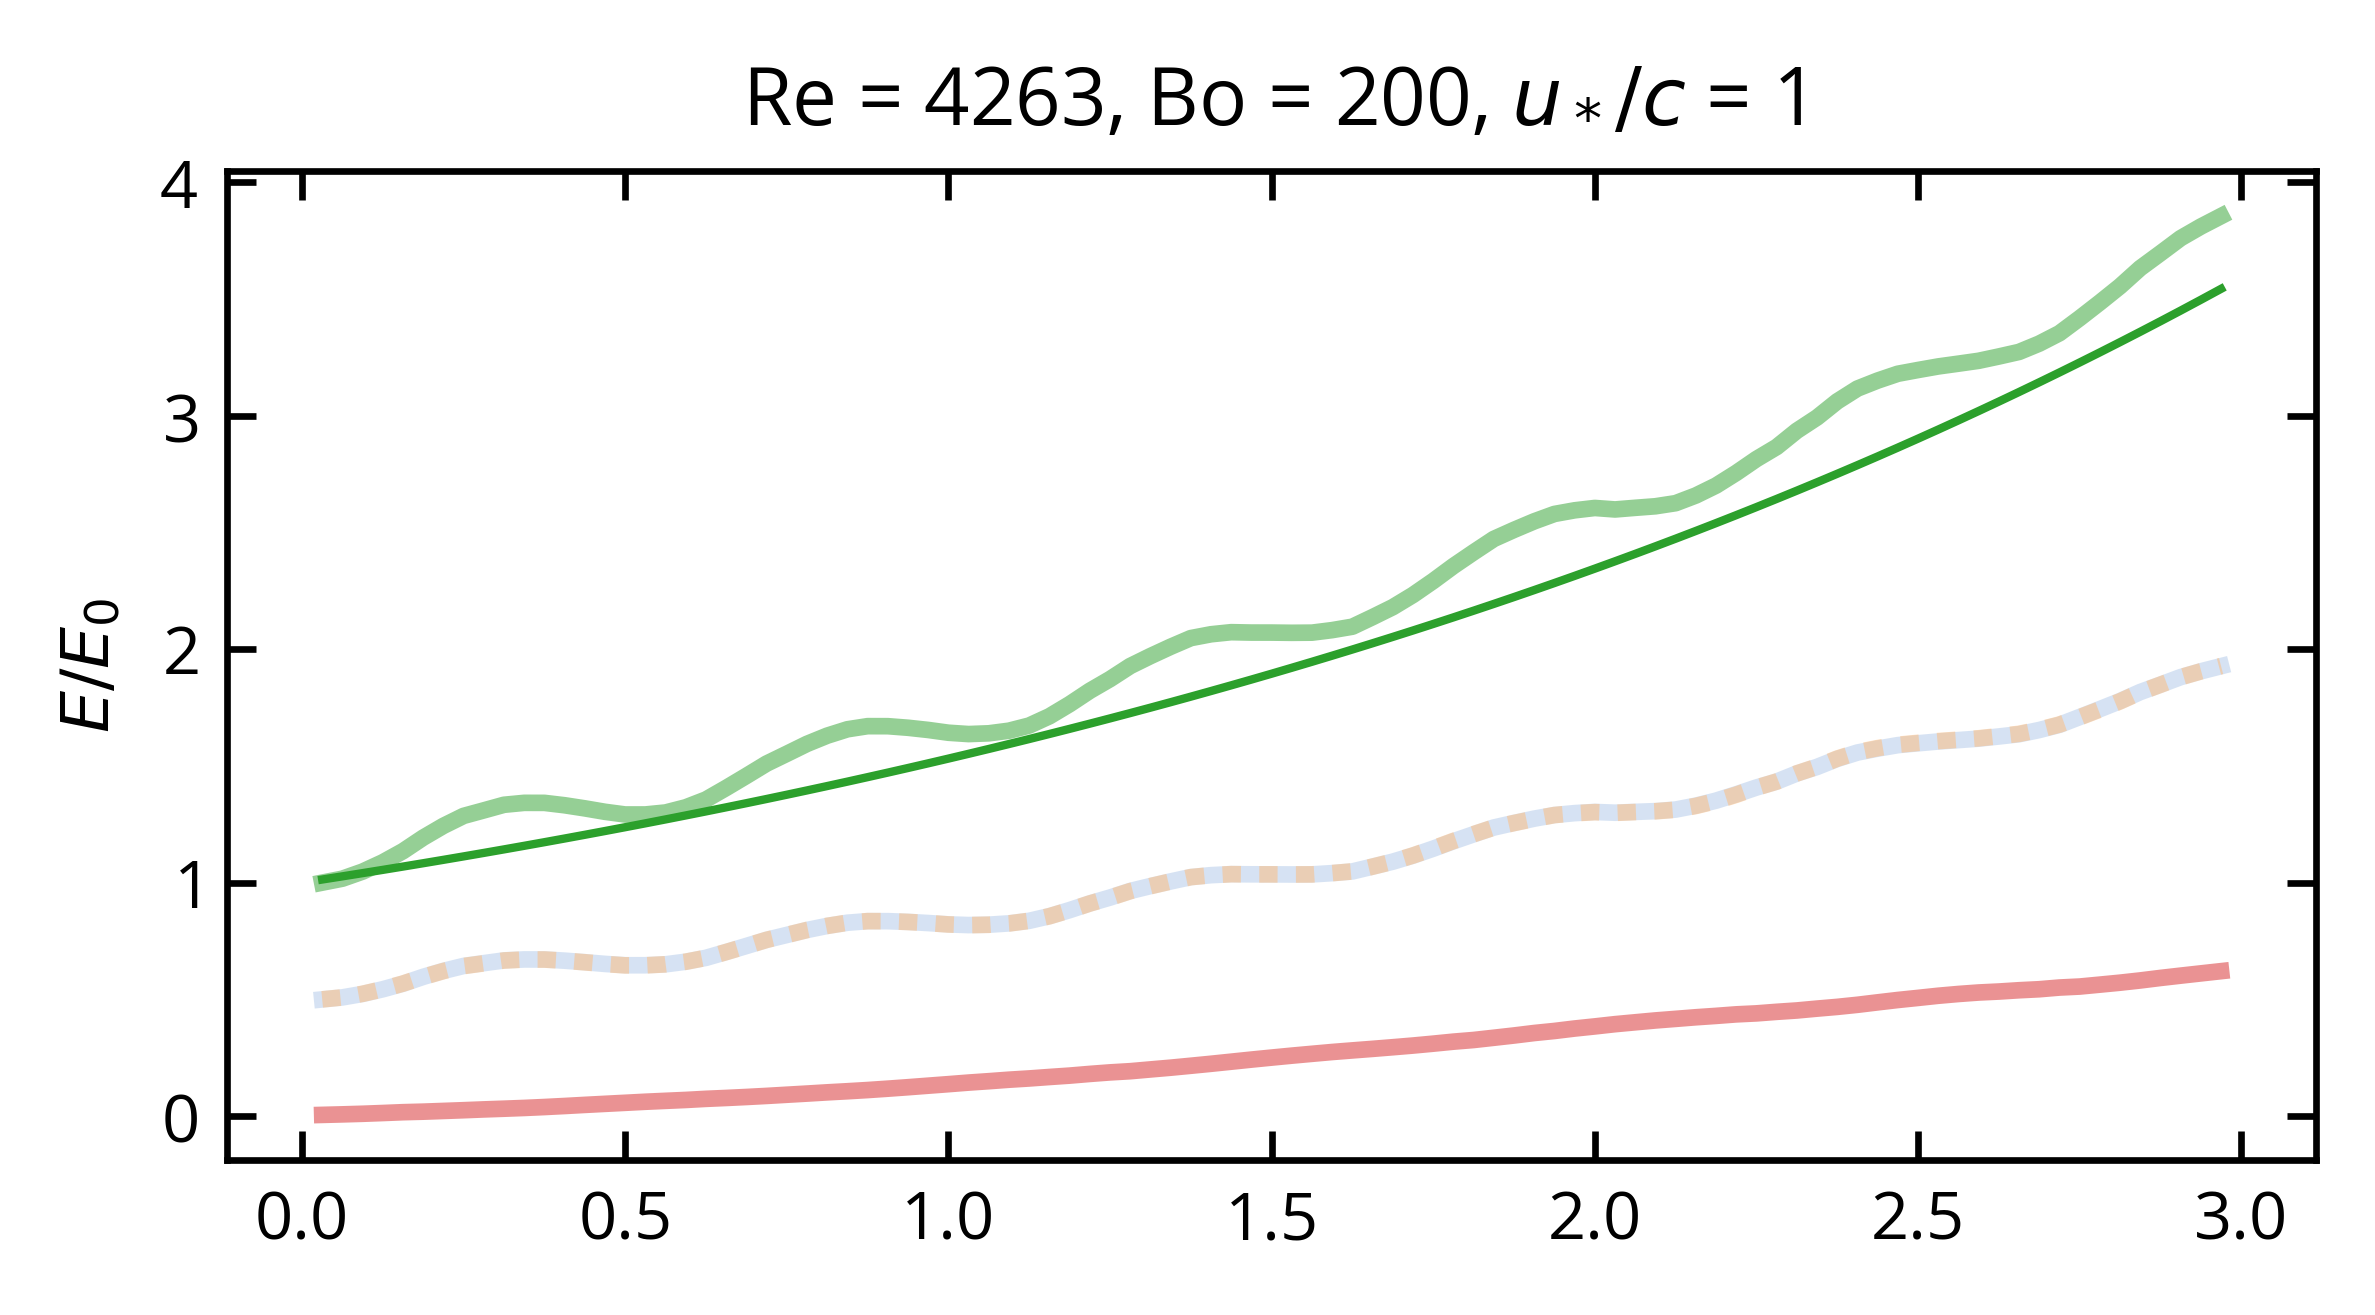

In [210]:
""" For revision. Plot drift kinetic energy too. """
case = case_Bo[8]
fig = plt.figure(figsize=[4,4])
ax1 = plt.subplot(211)
tend = 96

eta1,eta2,spectrum1,spectrum2 = case.spectrum_filtering(N_time = 280, N_padding = 9, WINDOW = True)
case.growth_rate_notfiltered(280, CAPI=True)

#Plot unfiltered energy (partition is not perfect)
ax1.plot(case.t[1:tend],case.ke_wave[1:tend]/case.energy_wave[1], '-', label=r'$E_k$', 
        color=plt.get_cmap('tab20')(1), alpha = 0.5, lw = 2)
ax1.plot(case.t[1:tend],case.pe_wave[1:tend]/case.energy_wave[1], ':', label=r'$E_g+E_s$', 
        color=plt.get_cmap('tab20')(3), alpha = 0.5, lw = 2)
ax1.plot(case.t[1:tend],case.energy_wave[1:tend]/case.energy_wave[1], '-', label=r'$E_g+E_s+E_k$', 
        color=plt.get_cmap('tab20')(4), alpha = 0.5, lw = 2)

case.wa,case.wb = np.polyfit(case.t[1:tend], np.log(case.energy_wave[1:tend]), 1)
print(case.wa)
ax1.plot(case.t[1:tend],np.exp(case.t[1:tend]*case.wa), 
         color=plt.get_cmap('tab20')(4), lw = 1) 
ax1.plot(case.t[1:tend],case.ke_drift[1:tend]/case.energy_wave[1], label='drift KE', 
        color=plt.get_cmap('tab20')(6), alpha = 0.5, lw = 2)
                   
# Plot filtered energy (partition is not perfect)                   
# eta1,eta2,spectrum1,spectrum2 = case.spectrum_filtering(N_time = 96, N_padding = 9, WINDOW = True)
# case.growth_rate(96, CAPI=True)
# print(case.wa)

# ax1.set_ylim([0,50])
ax1.set_ylabel(r'$E/E_0$')
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1)) 
ax1.yaxis.set_major_formatter(formatter)
plt.title('Re = %.0f, Bo = %g, $u_*/c$ = %g' %(case.Re*case.wave.c, case.Bo, case.ustar))

In [115]:
dEdt = case.energy_wave[64]*case.wa/(2*np.pi/case.wave.omega)
Dw = case.energy_wave[64]*(4*1/case.Re*case.wave.k**2)
print('dE/dt = %g' %dEdt)
print('Dw = %g' %Dw)

dE/dt = 1.37705e-05
Dw = 1.21725e-06


These are random snippets
____ 

In [130]:
from scipy.interpolate import interp1d

""" REWRITTEN water profile interpolation function! """
def water_profile_new(t,path,L0):
    # Read in the fields
    u_air, u_water, omega_air, omega_water = fields(path, t)
    # Average profile (wave coordinate!)
    u_water_interp = np.zeros(u_water.shape)
    ampl = interface(path, Npoint=512, L0=1, time=t)
#     zmax = L0/2 - ampl.eta_interp.max(); zmin = -L0/2 - ampl.eta_interp.min()
#     zgrid = np.linspace(zmin, zmax, 512) # The range of z'
    zplot = np.zeros(u_water.shape) # To show in the original cartesian grid z where the interpolating grid z' is
    for i in range(u_water.shape[0]):
        z = np.linspace(-L0/2,L0/2,512,endpoint=False) + L0/2/512
        f = interp1d(z, u_water[i,:])
        # The ratio to make sure that the cartesian representation of z' falls within the domain
        ratio = (L0/2 - np.abs(ampl.eta_interp[i]) - L0/2/512)/256 
        zgrid = ratio*np.arange(-256,256) + ampl.eta_interp[i] 
        zplot[i] = zgrid
        ugrid = f(zgrid)
        u_water_interp[i] = ugrid
    u_water_1D = np.average(u_water_interp[:,:], axis=0)
    return u_water, u_water_interp, u_water_1D, zgrid, zplot

u_water, u_water_interp, u_water_1D, ygrid, yplot_2D = water_profile_new(1,case.path,case.L0)

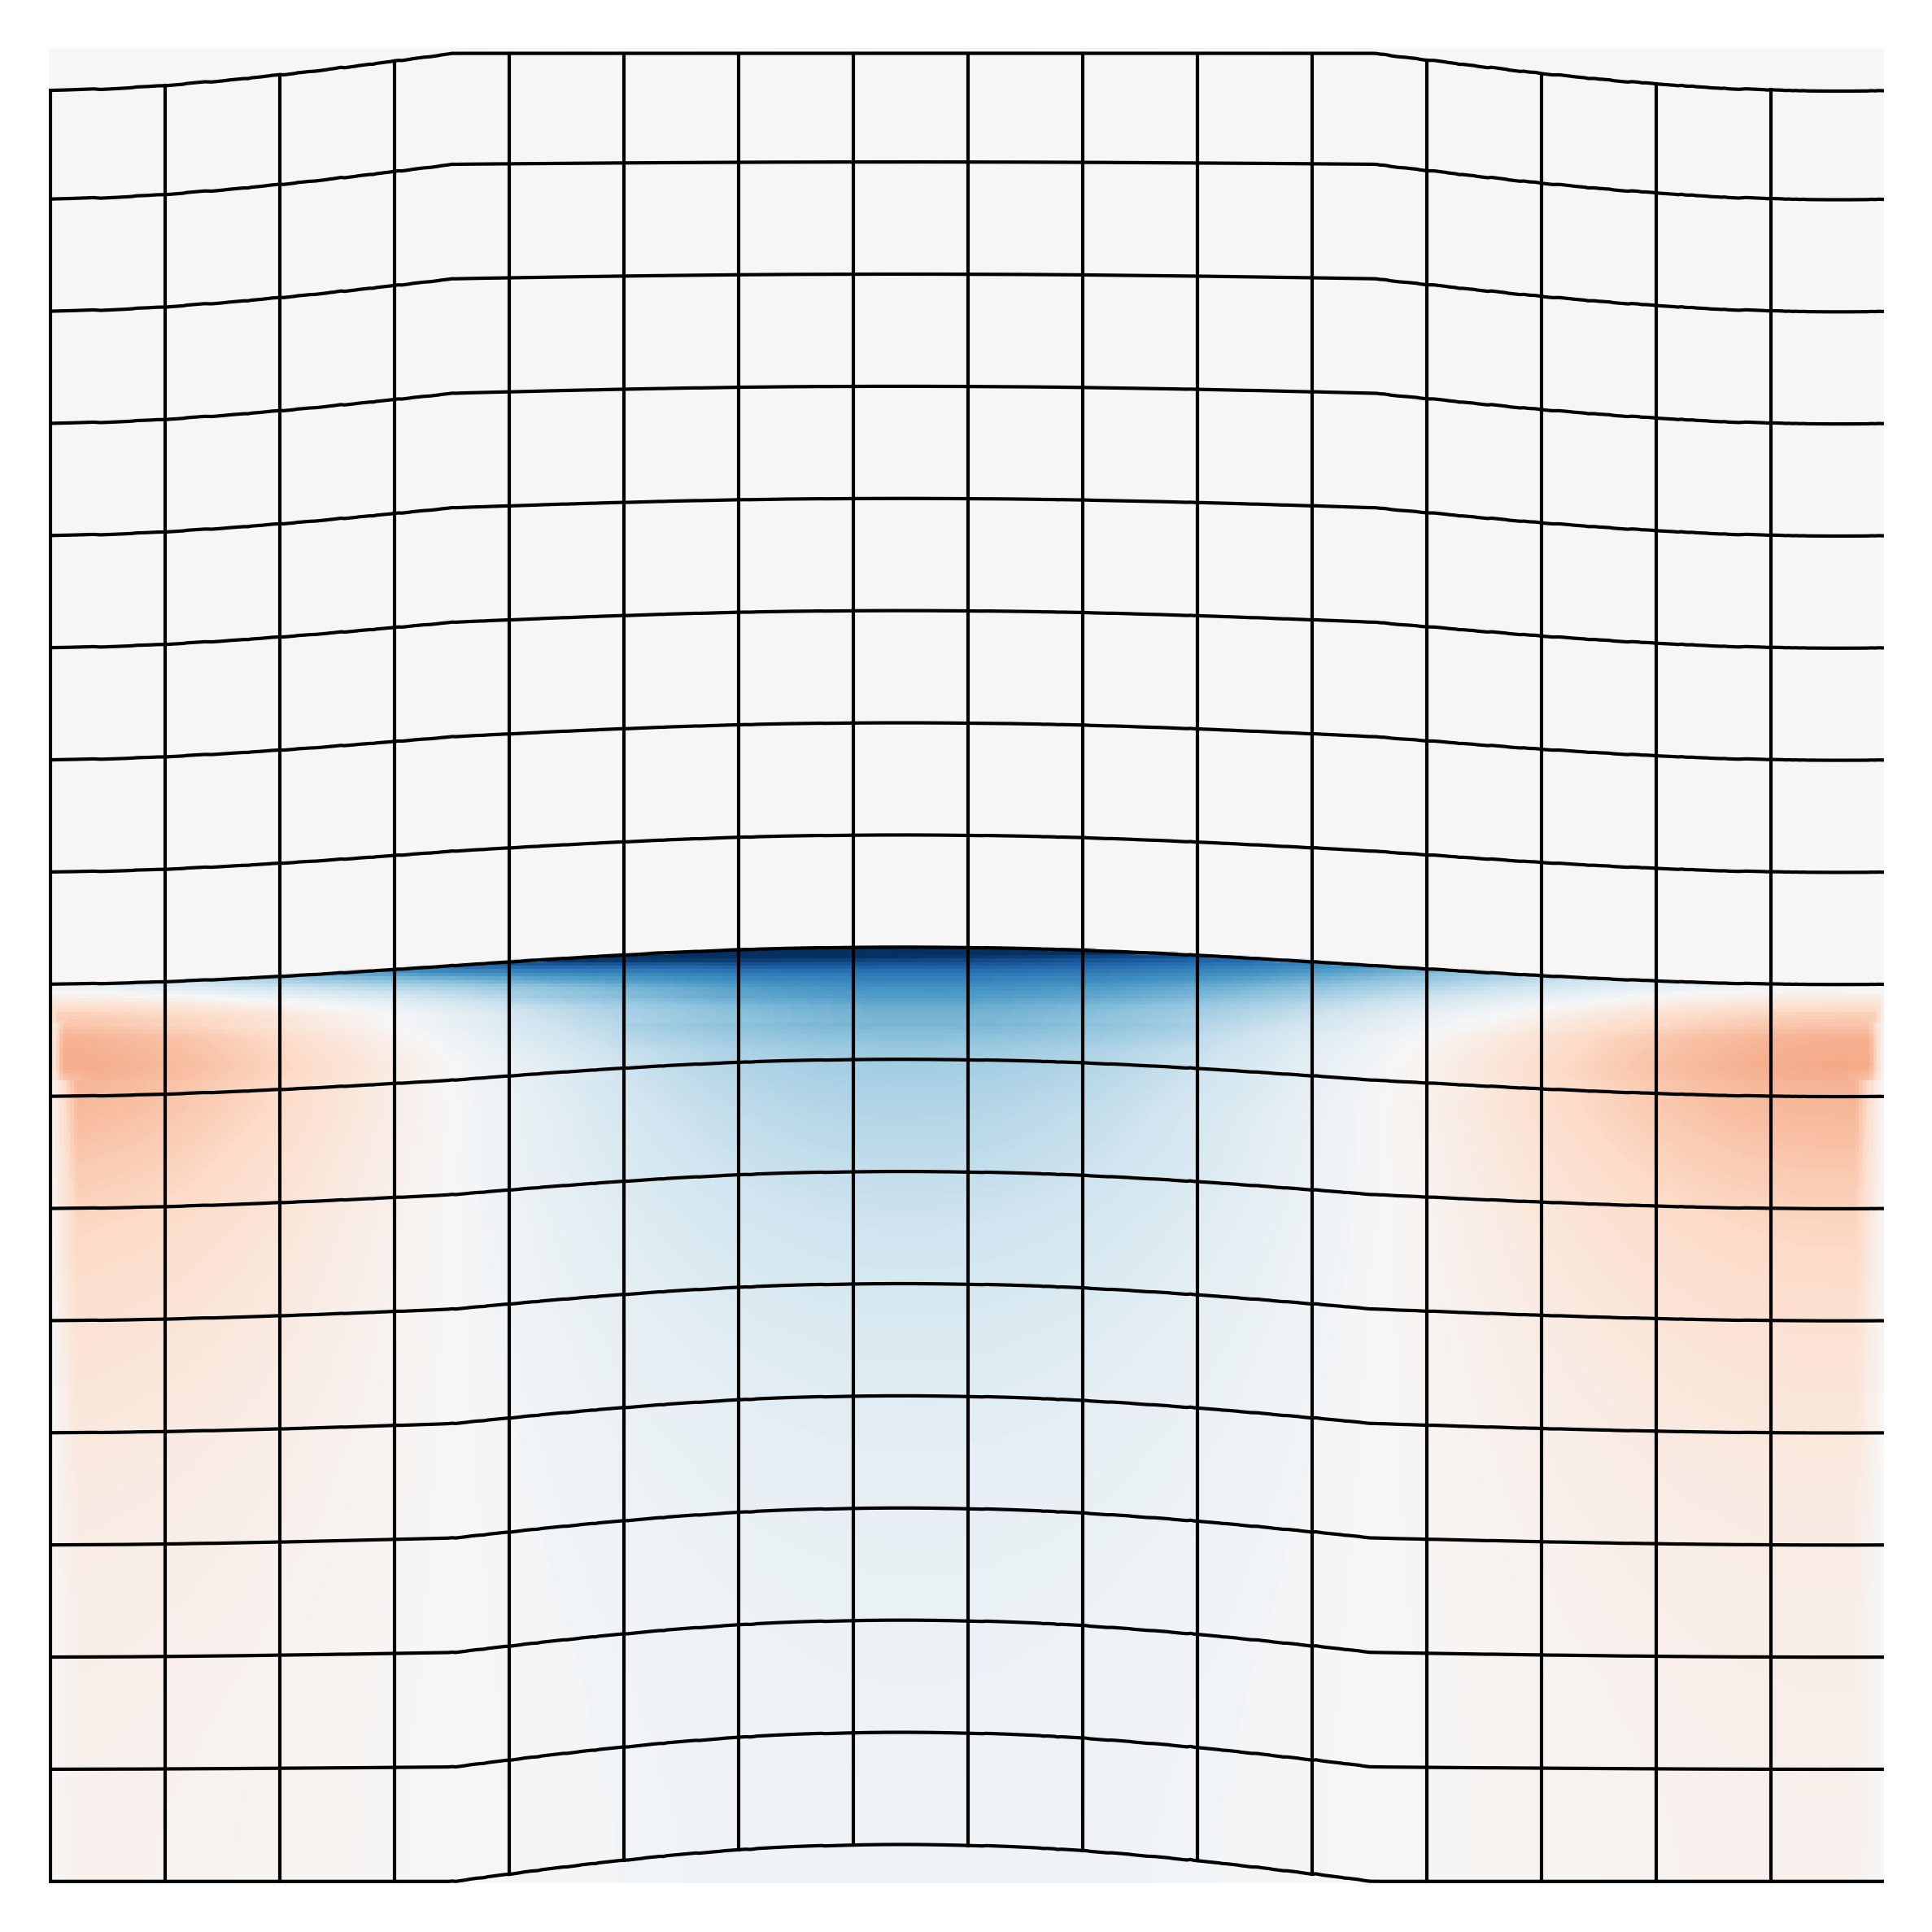

In [131]:
L0 = case.L0
plt.imshow(np.rot90(u_water),vmax = 0.05, vmin = -0.05, extent = (-L0/2,L0/2,-L0/2,L0/2), cmap='RdBu')
plt.axis('off')
for i in range(0,u_water.shape[0],32):
    x = (-L0/2 + L0/u_water.shape[0]*i + L0/u_water.shape[0]/2)*np.ones(u_water.shape[0])
    plt.plot(x, yplot_2D[i], c='k', lw = 0.5)

x = np.linspace(-L0/2,L0/2,512, endpoint=False) + L0/2/512
for i in range(0,u_water.shape[0],32):
    plt.plot(x, yplot_2D[:,i], c='k', lw = 0.5)
plt.plot(x, yplot_2D[:,-1], c='k', lw = 0.5)

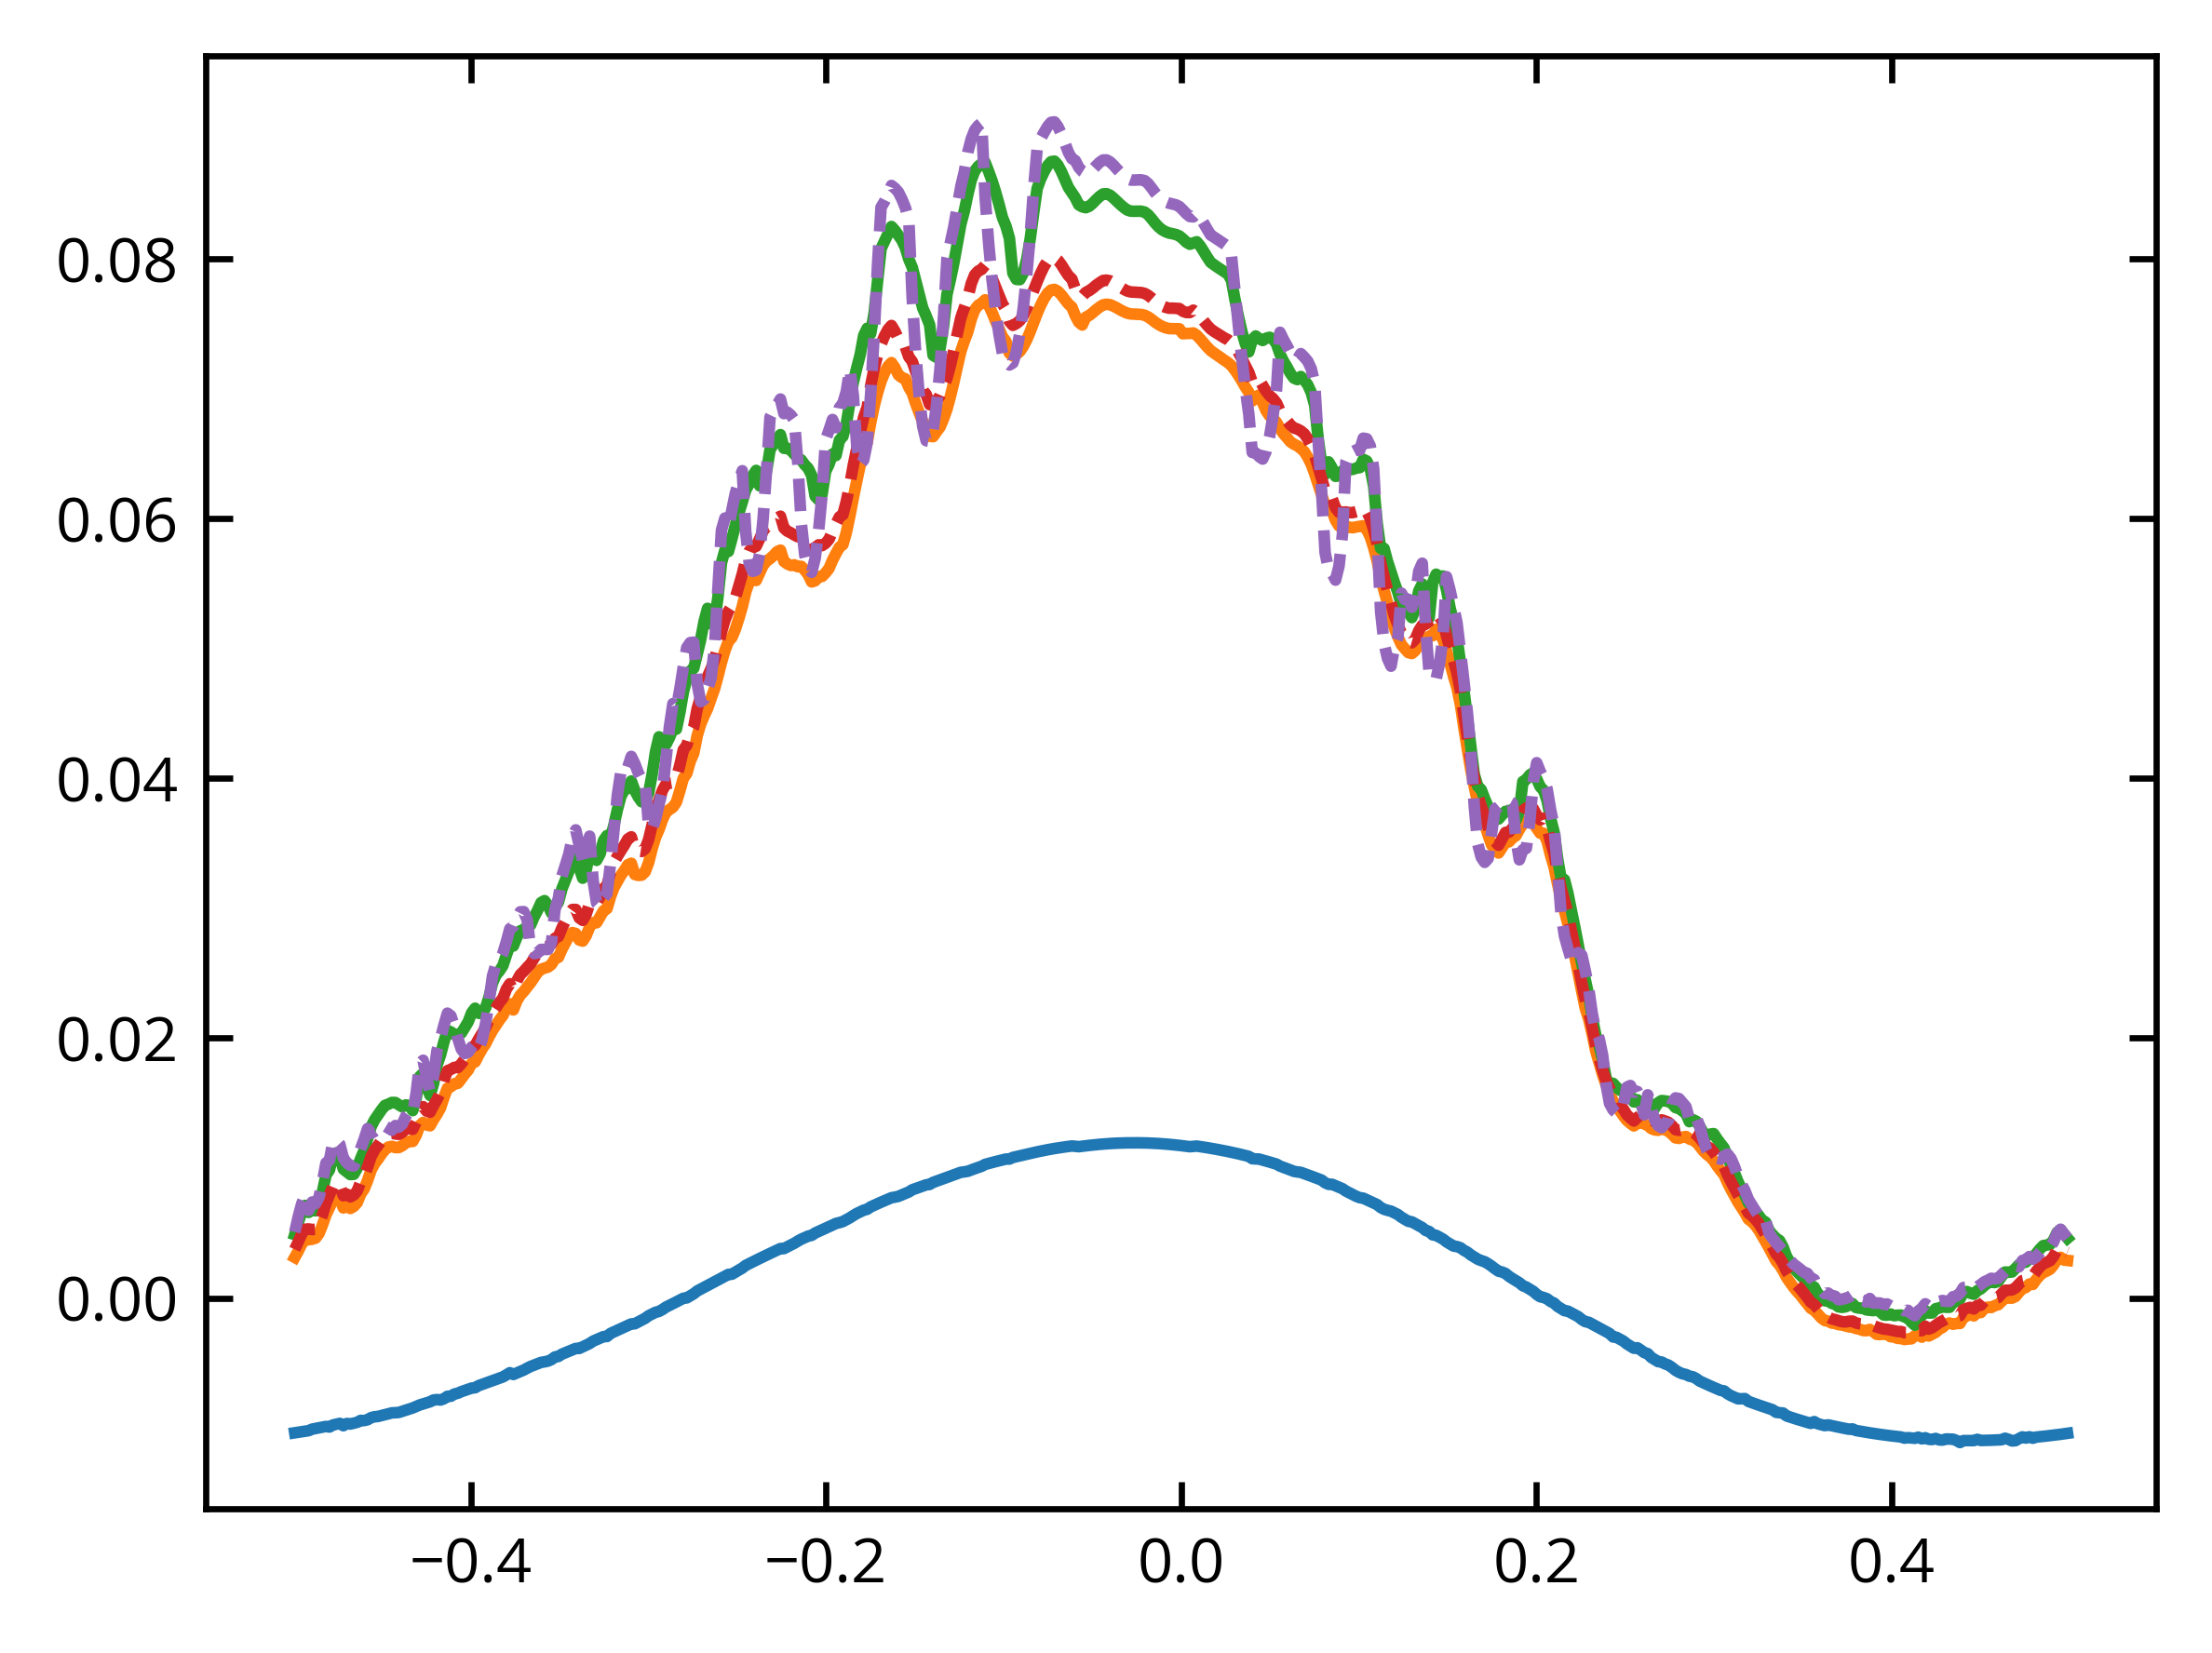

In [146]:
t = 1
x = np.linspace(-L0/2,L0/2,512, endpoint=False) + L0/2/512
ampl = interface(case.path, Npoint=512, L0=1, time=t)
plt.figure(figsize = [4,3])
plt.plot(x,ampl.eta_interp)

# Do we just compute the x, ux direction or both

u_water, u_water_interp, u_water_1D, ygrid, yplot_2D = water_profile_new(t,case.path,case.L0)
plt.plot(x,u_water_interp[:,254])
plt.plot(x,u_water_interp[:,255])
u_water, u_water_interp, u_water_1D, ygrid = water_profile(t,case.path,case.L0)
plt.plot(x,u_water_interp[:,254], '--')
plt.plot(x,u_water_interp[:,255], '--')

In [ ]:
def interface(common_path, Npoint=512, L0=1, time=0):
    etafile = common_path + '/field/eta%g' %time
    eta, exists = readin(etafile, table_delimiter = ',')
    if exists:
        eta.rename(columns={'pos':'eta'}, inplace=True)
        ampl = Amplitude(eta[['x', 'eta', 'f']], Npoint, L0)   
    return ampl

In [23]:
case = Case(ustar=0.5, ak=0.05, Bo=200, Re=20000., LEVEL=11, L0=1., g=1., k=2.*np.pi,
            working_dir = '/home/jiarong/research/projects/windwave/rerun/', 
            prefix = 'linear_wavewind_rerun_test_')

eta1,eta2,spectrum1,spectrum2 = case.spectrum_filtering(N_time = 192, N_padding = 9, WINDOW = True)